In [4]:
# UNet Inferencing Notebook
# This notebook provides a complete pipeline for inferencing with the trained UNet model on the LandCoverAI dataset

# Ignore warnings to avoid unnecessary clutter
import warnings
warnings.filterwarnings("ignore")

# Standard libraries for file handling and system operations
import os
import time
import glob
import shutil
from pathlib import Path

# Data manipulation and scientific libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors  # For custom color maps

# PyTorch and related libraries
import torch
from torch import nn
import torch.nn.functional as F
import torchvision.transforms.functional as TF  # For image transforms
from torch.utils.data import Dataset, DataLoader

# Image processing libraries
import cv2
import albumentations as A  # For advanced augmentations

# Set random seed for reproducibility
np.random.seed(42)

# Dataset and directory paths
DATASET_NAME = 'landcoverai'  # Dataset name
OUTPUT_DIR = os.path.join(os.getcwd(), "output")  # Output directory for saving results
IMGS_DIR = f"../input/{DATASET_NAME}/images"  # Path to images
MASKS_DIR = f"../input/{DATASET_NAME}/masks"  # Path to masks
DATA_ROOT = f"../input/{DATASET_NAME}"  # Root directory for dataset
IMG_PATHS = glob.glob(os.path.join(IMGS_DIR, "*.tif"))  # List all image files
MASK_PATHS = glob.glob(os.path.join(MASKS_DIR, "*.tif"))  # List all mask files

# Image and mask processing settings
IMAGE_SIZE = 512  # Image resizing size

# Custom color map for land-use labels (background, building, woodland, water, road)
labels_cmap = matplotlib.colors.ListedColormap(["#000000", "#A9A9A9", "#8B8680", "#D3D3D3", "#FFFFFF"])

# Class names
target_names = np.array(["background", "building", "woodland", "water", "road"])

# Set device to GPU if available, otherwise CPU
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# Double convolution block used in both the encoder and decoder parts of UNet
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, dilation=1):
        """
        Double convolutional layer with BatchNorm and ReLU activation.
        Args:
            in_channels (int): Number of input channels.
            out_channels (int): Number of output channels.
            dilation (int, optional): Dilation rate for convolutions. Defaults to 1.
        """
        super(DoubleConv, self).__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=dilation, stride=1, bias=False, dilation=dilation),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=dilation, stride=1, bias=False, dilation=dilation),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv_block(x)

# Main UNet architecture
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels, features=[64, 128, 256, 512], dilation_rates=(1, 1, 1, 1)):
        """
        UNet architecture for semantic segmentation.
        Args:
            in_channels (int): Number of input channels.
            out_channels (int): Number of output channels (number of classes).
            features (list of int, optional): Channels in each layer of encoder. Defaults to [64, 128, 256, 512].
            dilation_rates (tuple of int, optional): Dilation rates for each layer of encoder. Defaults to (1, 1, 1, 1).
        """
        super(UNet, self).__init__()
        self.encoder_blocks = nn.ModuleList()
        self.decoder_blocks = nn.ModuleList()
        self.pooling_layer = nn.MaxPool2d(kernel_size=2, stride=2)

        # Encoder: progressively downsample input while increasing channel depth
        for i, feature in enumerate(features):
            self.encoder_blocks.append(DoubleConv(in_channels, feature, dilation=dilation_rates[i]))
            in_channels = feature  # Update input channels for next block

        # Bottleneck: deepest part of the network
        self.bottleneck = DoubleConv(features[-1], features[-1] * 2)

        # Decoder: progressively upsample and decrease channel depth
        for i, feature in enumerate(reversed(features)):
            self.decoder_blocks.append(nn.ConvTranspose2d(feature * 2, feature, kernel_size=2, stride=2))  # Upsample
            self.decoder_blocks.append(DoubleConv(feature * 2, feature, dilation=dilation_rates[i]))  # Double convolution

        # Final 1x1 convolution for output
        self.output_conv = nn.Conv2d(features[0], out_channels, kernel_size=1, stride=1)

    def forward(self, x):
        skip_connections = []  # To store skip connections for concatenation in the decoder

        # Encoding path
        for encoder_block in self.encoder_blocks:
            x = encoder_block(x)
            skip_connections.append(x)  # Save output for skip connection
            x = self.pooling_layer(x)  # Downsample

        # Bottleneck
        x = self.bottleneck(x)

        # Reverse order of skip connections for the decoder
        skip_connections = skip_connections[::-1]

        # Decoding path
        for idx in range(0, len(self.decoder_blocks), 2):
            x = self.decoder_blocks[idx](x)  # Upsample
            skip_connection = skip_connections[idx // 2]  # Fetch corresponding skip connection

            # Ensure size alignment for concatenation
            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            # Concatenate skip connection
            x = torch.cat((skip_connection, x), dim=1)
            x = self.decoder_blocks[idx + 1](x)  # Apply double conv block

        # Output layer
        return self.output_conv(x)

def split_images(TARGET_SIZE=IMAGE_SIZE):
    """
    Splits aerial images and masks into tiles of size TARGET_SIZE, saving
    them in the output directory.
    """
    tic = time.time()
    
    if Path(OUTPUT_DIR).exists():
        shutil.rmtree(OUTPUT_DIR)
    os.makedirs(OUTPUT_DIR)
    
    for img_path, mask_path in zip(IMG_PATHS, MASK_PATHS):
        print(f"Processing: {os.path.basename(img_path)}")
        img, mask = cv2.imread(img_path), cv2.imread(mask_path)
        
        for k, (y, x) in enumerate((y, x) for y in range(0, img.shape[0], TARGET_SIZE) for x in range(0, img.shape[1], TARGET_SIZE)):
            img_tile, mask_tile = img[y:y + TARGET_SIZE, x:x + TARGET_SIZE], mask[y:y + TARGET_SIZE, x:x + TARGET_SIZE]
            if img_tile.shape[:2] == (TARGET_SIZE, TARGET_SIZE):
                base_name = os.path.splitext(os.path.basename(img_path))[0]
                cv2.imwrite(f"{OUTPUT_DIR}/{base_name}_{k}.jpg", img_tile)
                cv2.imwrite(f"{OUTPUT_DIR}/{base_name}_{k}_m.png", mask_tile)
    
    mins, sec = divmod(time.time() - tic, 60)
    print(f"Completed in {mins:.0f}m {sec:.2f}s.")
    print(f"Total tiles created: {len(glob.glob(os.path.join(OUTPUT_DIR, '*.jpg')))}")

class SegmentationDataset(Dataset):
    """Handles dataset reading and conversion to tensors."""
    def __init__(self, mode="test", ratio=None, transforms=None, seed=42):
        if mode not in {"train", "test", "val"}:
            raise ValueError(f"Mode must be 'train', 'val', or 'test', not '{mode}'.")
        
        self.mode, self.transforms, self.output_dir = mode, transforms, OUTPUT_DIR
        with open(os.path.join(DATA_ROOT, f"{mode}.txt")) as f:
            self.img_names = f.read().splitlines()
        
        if ratio:
            print(f"Using {100*ratio:.2f}% of {mode} set --> {int(ratio * len(self.img_names))}/{len(self.img_names)}")
            np.random.seed(seed)
            self.indices = np.random.choice(len(self.img_names), int(ratio * len(self.img_names)), replace=False)
        else:
            print(f"Using the whole {mode} set --> {len(self.img_names)}")
            self.indices = range(len(self.img_names))

    def __getitem__(self, item):
        img_name = os.path.join(self.output_dir, f"{self.img_names[self.indices[item]]}")
        img = cv2.imread(f"{img_name}.jpg")
        mask = cv2.imread(f"{img_name}_m.png")[:, :, 1]  # Extract green channel

        if self.transforms:
            transformed = self.transforms(image=img, mask=mask)
            img, mask = transformed["image"], transformed["mask"]

        img = np.transpose(img, (2, 0, 1))  # Convert to CxHxW
        return torch.tensor(img, dtype=torch.float32) / 255, torch.tensor(mask, dtype=torch.int64)

    def __len__(self):
        return len(self.indices)
        
def load_model(model_path):
    """
    Load a trained UNet model from disk.
    Args:
        model_path (str): Path to the saved model state dictionary.
    Returns:
        model: The loaded UNet model.
    """
    # Initialize the model
    model = UNet(in_channels=3, out_channels=len(target_names)).to(device)
    
    # Load the state dictionary
    try:
        model.load_state_dict(torch.load(model_path, map_location=device))
        print(f"Model loaded successfully from {model_path}")
    except Exception as e:
        print(f"Error loading model: {e}")
        return None
    
    # Set to evaluation mode
    model.eval()
    return model

def predict_single_image(model, image_path):
    """
    Make a prediction on a single image.
    Args:
        model: The trained UNet model.
        image_path (str): Path to the input image.
    Returns:
        pred: The predicted segmentation mask.
        img: The original image.
    """
    # Load and preprocess the image
    img = cv2.imread(image_path)
    img_tensor = torch.tensor(np.transpose(img, (2, 0, 1)), dtype=torch.float32).unsqueeze(0) / 255
    img_tensor = img_tensor.to(device)
    
    # Make prediction
    with torch.no_grad():
        output = model(img_tensor)
        pred = torch.argmax(output, dim=1).squeeze().cpu().numpy()
    
    return pred, img

def visualize_results(model, test_set, num_samples=4, seed=42, figsize=(15, 15), indices=None):
    """
    Visualize model predictions alongside ground truth.
    Args:
        model: The trained UNet model.
        test_set: The dataset to test on.
        num_samples (int): Number of samples to visualize.
        seed (int): Random seed for reproducibility.
        figsize (tuple): Figure size for the plot.
        indices (list, optional): Specific indices to visualize. If None, random samples are chosen.
    """
    np.random.seed(seed)
    if indices is None:
        indices = np.random.randint(low=0, high=len(test_set), size=num_samples)
    
    fig, ax = plt.subplots(figsize=figsize, nrows=num_samples, ncols=3)
    
    for i, idx in enumerate(indices):
        X, y = test_set[idx]
        X_dash = X.unsqueeze(0).to(device)
        
        with torch.no_grad():
            preds = torch.argmax(model(X_dash), dim=1)
            preds = torch.squeeze(preds).detach().cpu().numpy()
        
        # Original image
        ax[i, 0].imshow(np.transpose(X.cpu().numpy(), (1, 2, 0)))
        ax[i, 0].set_title("Original Image")
        ax[i, 0].axis("off")
        
        # Ground truth
        ax[i, 1].imshow(y, cmap=labels_cmap, interpolation=None, vmin=-0.5, vmax=4.5)
        ax[i, 1].set_title("Ground Truth")
        ax[i, 1].axis("off")
        
        # Prediction
        ax[i, 2].imshow(preds, cmap=labels_cmap, interpolation=None, vmin=-0.5, vmax=4.5)
        ax[i, 2].set_title("Prediction")
        ax[i, 2].axis("off")
    
    plt.tight_layout()
    plt.savefig("prediction_results.png", bbox_inches="tight")
    plt.show()

def calculate_metrics(model, test_loader):
    """
    Calculate accuracy and IoU metrics on the test set.
    Args:
        model: The trained UNet model.
        test_loader: DataLoader for the test dataset.
    Returns:
        accuracy: Overall pixel accuracy.
        class_iou: IoU for each class.
    """
    model.eval()
    correct = 0
    total = 0
    class_intersection = np.zeros(len(target_names))
    class_union = np.zeros(len(target_names))
    
    with torch.no_grad():
        for images, masks in test_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            predictions = torch.argmax(outputs, dim=1)
            
            # Calculate accuracy
            correct += (predictions == masks).sum().item()
            total += masks.numel()
            
            # Calculate IoU for each class
            for class_idx in range(len(target_names)):
                pred_mask = (predictions == class_idx)
                true_mask = (masks == class_idx)
                intersection = (pred_mask & true_mask).sum().item()
                union = (pred_mask | true_mask).sum().item()
                
                class_intersection[class_idx] += intersection
                class_union[class_idx] += union
    
    # Calculate overall accuracy
    accuracy = correct / total
    
    # Calculate IoU for each class
    class_iou = np.zeros(len(target_names))
    for class_idx in range(len(target_names)):
        if class_union[class_idx] > 0:
            class_iou[class_idx] = class_intersection[class_idx] / class_union[class_idx]
    
    # Calculate mean IoU
    mean_iou = np.mean(class_iou)
    
    # Print results
    print(f"Overall Accuracy: {accuracy:.4f}")
    print(f"Mean IoU: {mean_iou:.4f}")
    print("\nClass-wise IoU:")
    for class_idx, iou in enumerate(class_iou):
        print(f"  - {target_names[class_idx]}: {iou:.4f}")
    
    return accuracy, class_iou

def predict_all_test_images(model, test_loader, num_to_visualize=8):
    """
    Make predictions on all test images and visualize a subset.
    Args:
        model: The trained UNet model.
        test_loader: DataLoader for the test dataset.
        num_to_visualize (int): Number of random results to visualize.
    """
    model.eval()
    all_predictions = []
    all_ground_truth = []
    all_images = []
    
    with torch.no_grad():
        for images, masks in test_loader:
            images = images.to(device)
            outputs = model(images)
            predictions = torch.argmax(outputs, dim=1)
            
            # Store results
            all_predictions.extend([pred.cpu().numpy() for pred in predictions])
            all_ground_truth.extend([mask.cpu().numpy() for mask in masks])
            all_images.extend([img.cpu().numpy() for img in images])
    
    print(f"Made predictions on {len(all_predictions)} test images")
    
    # Visualize random subset
    indices = np.random.choice(len(all_predictions), min(num_to_visualize, len(all_predictions)), replace=False)
    
    fig, axes = plt.subplots(len(indices), 3, figsize=(15, 5*len(indices)))
    
    for i, idx in enumerate(indices):
        # Original image
        axes[i, 0].imshow(np.transpose(all_images[idx], (1, 2, 0)))
        axes[i, 0].set_title("Original Image")
        axes[i, 0].axis("off")
        
        # Ground truth
        axes[i, 1].imshow(all_ground_truth[idx], cmap=labels_cmap, interpolation=None, vmin=-0.5, vmax=4.5)
        axes[i, 1].set_title("Ground Truth")
        axes[i, 1].axis("off")
        
        # Prediction
        axes[i, 2].imshow(all_predictions[idx], cmap=labels_cmap, interpolation=None, vmin=-0.5, vmax=4.5)
        axes[i, 2].set_title("Prediction")
        axes[i, 2].axis("off")
    
    plt.tight_layout()
    plt.savefig("batch_prediction_results.png", bbox_inches="tight")
    plt.show()

# Create legend for color map
def show_color_legend():
    """Display a legend for the color map used in segmentation visualization."""
    fig, ax = plt.subplots(figsize=(8, 2))
    
    # Create a color swatch for each class
    for i, (name, color) in enumerate(zip(target_names, labels_cmap.colors)):
        ax.add_patch(plt.Rectangle((i, 0), 0.9, 0.9, color=color))
        ax.text(i + 0.45, 0.5, name, ha='center', va='center', 
                fontsize=12, fontweight='bold', 
                color='white' if i == 0 else 'black')  # White text for background class
    
    ax.set_xlim(-0.1, len(target_names))
    ax.set_ylim(-0.1, 1)
    ax.set_title("Land Cover Classes", fontsize=14)
    ax.axis('off')
    
    plt.tight_layout()
    plt.savefig("color_legend.png", bbox_inches="tight")
    plt.show()



Using device: cuda


In [5]:
split_images()

Processing: M-34-77-B-c-2-3.tif
Processing: N-33-139-C-d-2-2.tif
Processing: M-34-51-C-d-4-1.tif
Processing: N-34-97-C-b-1-2.tif
Processing: M-34-65-D-a-4-4.tif
Processing: N-33-130-A-d-3-3.tif
Processing: M-34-65-D-c-4-2.tif
Processing: N-33-130-A-d-4-4.tif
Processing: N-34-77-A-b-1-4.tif
Processing: N-34-106-A-c-1-3.tif
Processing: M-34-68-B-a-1-3.tif
Processing: M-34-32-B-a-4-3.tif
Processing: N-33-60-D-c-4-2.tif
Processing: M-34-55-B-b-4-1.tif
Processing: M-33-7-A-d-2-3.tif
Processing: N-33-96-D-d-1-1.tif
Processing: N-34-106-A-b-3-4.tif
Processing: M-34-56-A-b-1-4.tif
Processing: M-33-32-B-b-4-4.tif
Processing: M-33-7-A-d-3-2.tif
Processing: M-34-32-B-b-1-3.tif
Processing: N-33-60-D-d-1-2.tif
Processing: M-33-20-D-d-3-3.tif
Processing: M-33-20-D-c-4-2.tif
Processing: M-34-65-D-d-4-1.tif
Processing: M-34-51-C-b-2-1.tif
Processing: N-34-94-A-b-2-4.tif
Processing: N-34-140-A-d-3-4.tif
Processing: N-34-97-D-c-2-4.tif
Processing: M-33-48-A-c-4-4.tif
Processing: N-33-119-C-c-3-3.tif
Pro

In [6]:
test_set = SegmentationDataset(mode="test", )

Using the whole test set --> 1602


In [4]:
test_loader = DataLoader(test_set, batch_size=8, num_workers=2)

In [5]:
model_path = "/kaggle/input/unet-model-landcover-ai/pytorch/default/1/best_unet_model_0.25_loss"  # Update this to your model path
model = load_model(model_path)

Model loaded successfully from /kaggle/input/unet-model-landcover-ai/pytorch/default/1/best_unet_model_0.25_loss


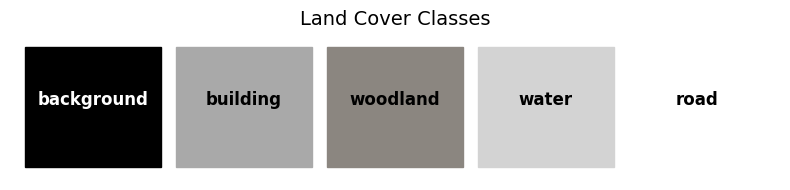

In [6]:
show_color_legend()

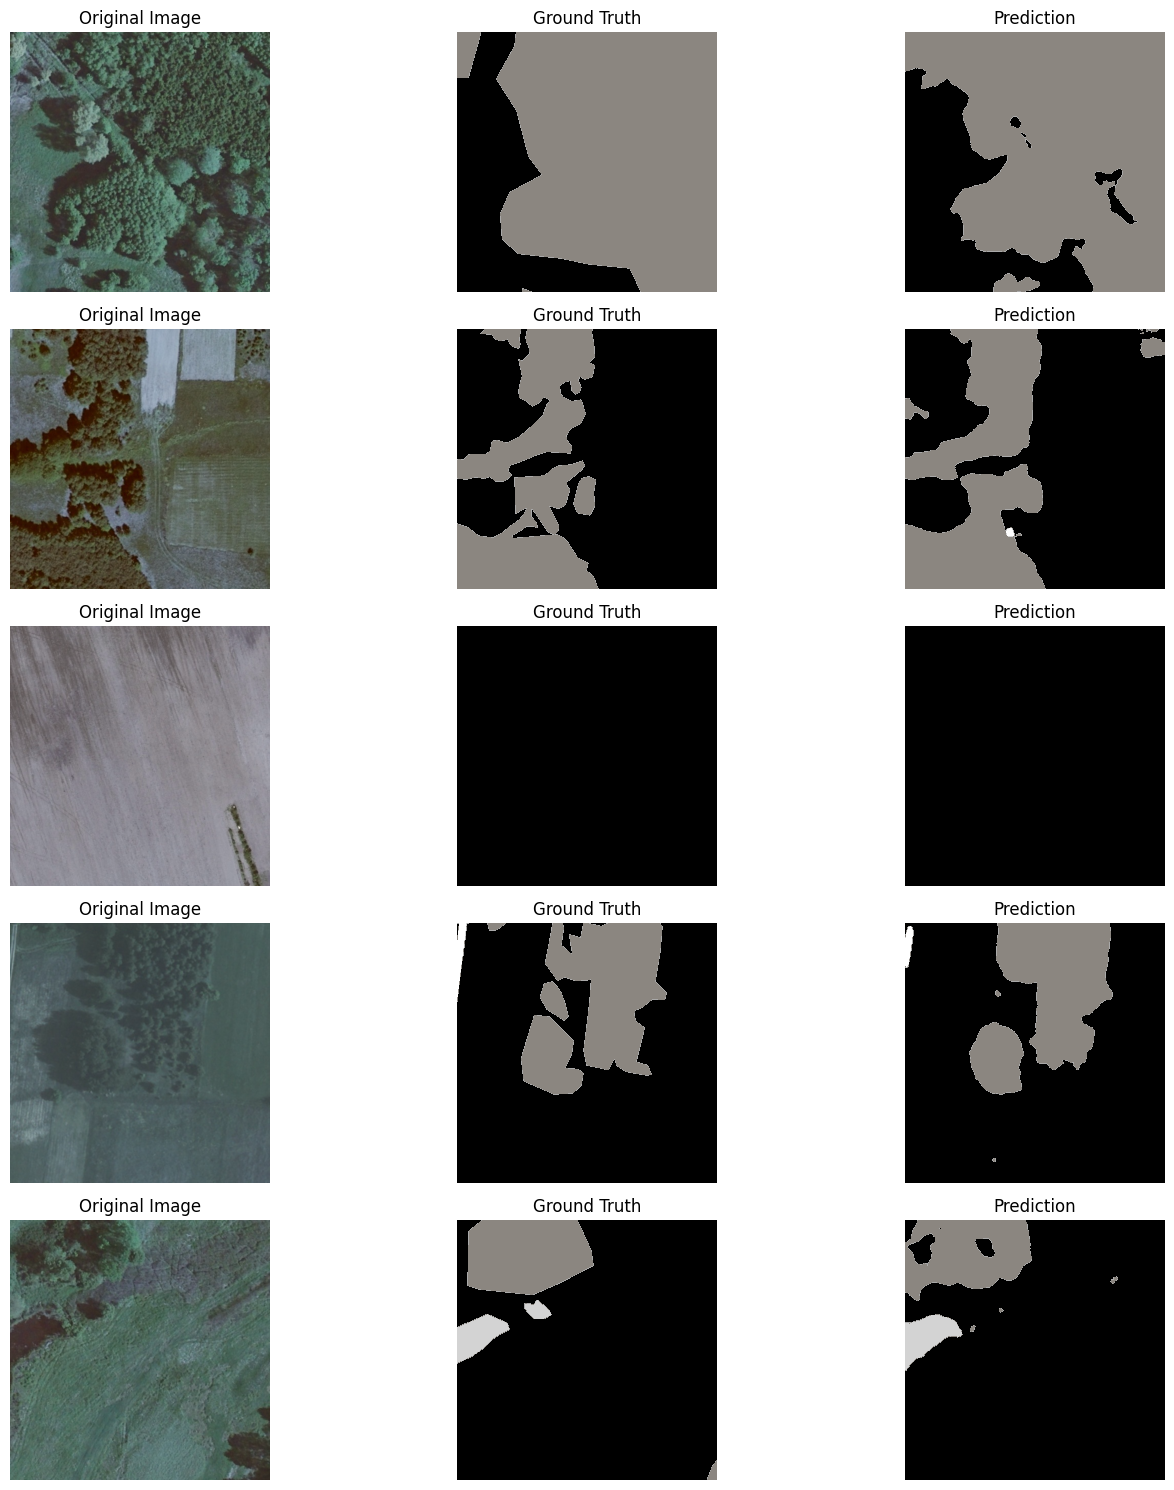

In [7]:
visualize_results(model, test_set, num_samples=5)

In [8]:
accuracy, iou = calculate_metrics(model, test_loader)

Overall Accuracy: 0.9308
Mean IoU: 0.7741

Class-wise IoU:
  - background: 0.8911
  - building: 0.7145
  - woodland: 0.8660
  - water: 0.8362
  - road: 0.5624


In [ ]:
predict_all_test_images(model, test_loader)


------------------------------------------------------------------------------------------

In [10]:
# Memory-Efficient Bottleneck Feature Extraction BUILDING
# This script extracts bottleneck features with optimized memory usage

import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Subset
import h5py
from tqdm import tqdm
import gc  # Garbage collection

def create_bottleneck_extractor(model):
    """
    Modify the U-Net model to extract bottleneck features.
    Args:
        model: The trained UNet model.
    Returns:
        bottleneck_model: Model that outputs bottleneck features.
    """
    class BottleneckExtractor(torch.nn.Module):
        def __init__(self, original_model):
            super(BottleneckExtractor, self).__init__()
            self.encoder_blocks = original_model.encoder_blocks
            self.pooling_layer = original_model.pooling_layer
            self.bottleneck = original_model.bottleneck
            
        def forward(self, x):
            # Pass through encoder
            skip_connections = []
            for encoder_block in self.encoder_blocks:
                x = encoder_block(x)
                skip_connections.append(x)
                x = self.pooling_layer(x)
                
            # Pass through bottleneck
            bottleneck_features = self.bottleneck(x)
            
            return bottleneck_features
    
    # Create and return the bottleneck extractor
    bottleneck_model = BottleneckExtractor(model)
    bottleneck_model.eval()  # Set to evaluation mode
    return bottleneck_model

def extract_batch_statistics(model, dataloader, device, has_building_threshold=0.005):
    """
    Process batches and extract bottleneck statistics instead of storing all features.
    
    Args:
        model: The bottleneck extractor model.
        dataloader: DataLoader for the dataset.
        device: Device to run model on (cuda/cpu).
        has_building_threshold: Minimum fraction of building pixels to consider a patch as containing buildings.
    
    Returns:
        Dictionary of bottleneck statistics for building/non-building patches.
    """
    # Initialize statistics
    building_stats = {
        'count': 0,
        'channel_means': None,
        'channel_maxes': None,
        'magnitude_sum': 0,
        'samples': []  # Store a few examples for visualization
    }
    
    non_building_stats = {
        'count': 0,
        'channel_means': None,
        'channel_maxes': None,
        'magnitude_sum': 0,
        'samples': []  # Store a few examples for visualization
    }
    
    sample_count = {'building': 0, 'non_building': 0}
    max_samples = 10  # Maximum number of samples to store for each category
    
    # Process all batches
    with torch.no_grad():
        for batch_idx, (images, masks) in enumerate(tqdm(dataloader, desc="Processing batches")):
            # Move images to device
            images = images.to(device)
            
            # Extract bottleneck features
            bottleneck_features = model(images)
            
            # Move back to CPU and convert to numpy to free up GPU memory
            bottleneck_features = bottleneck_features.cpu().numpy()
            
            # Process each sample in the batch
            for i, mask in enumerate(masks):
                # Calculate ratio of building pixels (class 1) to total pixels
                building_pixels = (mask == 1).sum().item()
                total_pixels = mask.numel()
                building_ratio = building_pixels / total_pixels
                
                # Determine if patch has buildings based on threshold
                has_building = building_ratio > has_building_threshold
                
                # Get feature for this sample
                feature = bottleneck_features[i]
                
                # Calculate statistics for this feature
                channel_mean = np.mean(feature, axis=(1, 2))  # Mean across spatial dimensions
                channel_max = np.max(feature, axis=(1, 2))    # Max across spatial dimensions
                magnitude = np.mean(np.abs(feature))          # Overall activation magnitude
                
                # Add to appropriate statistics bucket
                if has_building:
                    stats = building_stats
                    sample_type = 'building'
                else:
                    stats = non_building_stats
                    sample_type = 'non_building'
                
                stats['count'] += 1
                
                # Initialize channel statistics if this is the first sample
                if stats['channel_means'] is None:
                    stats['channel_means'] = channel_mean
                    stats['channel_maxes'] = channel_max
                else:
                    # Incremental update of means (to avoid storing all features)
                    stats['channel_means'] = (stats['channel_means'] * (stats['count'] - 1) + channel_mean) / stats['count']
                    # For max, we use element-wise maximum
                    stats['channel_maxes'] = np.maximum(stats['channel_maxes'], channel_max)
                
                # Update magnitude sum
                stats['magnitude_sum'] += magnitude
                
                # Store sample for visualization if needed
                if sample_count[sample_type] < max_samples:
                    # Store the original image, mask, and some bottleneck stats
                    stats['samples'].append({
                        'image': images[i].cpu().numpy(),
                        'mask': mask.numpy(),
                        'bottleneck_mean': np.mean(feature),
                        'bottleneck_std': np.std(feature),
                        'bottleneck_max': np.max(feature),
                        'building_ratio': building_ratio,
                        'channel_mean': channel_mean
                    })
                    sample_count[sample_type] += 1
            
            # Force garbage collection to free memory
            del bottleneck_features
            gc.collect()
            
            # Clear CUDA cache if using GPU
            if device == 'cuda':
                torch.cuda.empty_cache()
    
    # Calculate final statistics
    if building_stats['count'] > 0:
        building_stats['magnitude_mean'] = building_stats['magnitude_sum'] / building_stats['count']
    
    if non_building_stats['count'] > 0:
        non_building_stats['magnitude_mean'] = non_building_stats['magnitude_sum'] / non_building_stats['count']
    
    return {
        'building': building_stats,
        'non_building': non_building_stats
    }

def analyze_channel_differences(stats, top_n=10, save_path=None):
    """
    Analyze which channels show the biggest differences between building and non-building patches.
    
    Args:
        stats: Dictionary containing bottleneck statistics.
        top_n: Number of top discriminative channels to identify.
        save_path: Path to save the visualization.
    
    Returns:
        List of top discriminative channel indices.
    """
    building_means = stats['building']['channel_means']
    non_building_means = stats['non_building']['channel_means']
    
    # Calculate absolute difference between means
    channel_diff = np.abs(building_means - non_building_means)
    
    # Find channels with largest differences
    top_channels = np.argsort(channel_diff)[::-1][:top_n]
    
    # Plot differences for all channels
    plt.figure(figsize=(12, 6))
    plt.bar(range(len(channel_diff)), channel_diff)
    plt.title('Absolute Difference in Mean Activation Between Building and Non-Building Patches')
    plt.xlabel('Channel Index')
    plt.ylabel('Absolute Difference')
    
    # Highlight top channels
    plt.bar(top_channels, channel_diff[top_channels], color='red')
    
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
    
    plt.show()
    
    # Print statistics for top channels
    print(f"\nTop {top_n} discriminative channels:")
    for i, channel in enumerate(top_channels):
        print(f"{i+1}. Channel {channel}: Difference = {channel_diff[channel]:.4f}")
        print(f"   Building mean: {building_means[channel]:.4f}")
        print(f"   Non-building mean: {non_building_means[channel]:.4f}")
        print(f"   Ratio: {building_means[channel]/max(0.0001, non_building_means[channel]):.2f}x")
    
    return list(top_channels)

def visualize_sample_patches(stats, save_path=None):
    """
    Visualize sample patches alongside their bottleneck statistics.
    
    Args:
        stats: Dictionary containing bottleneck statistics and samples.
        save_path: Path to save the visualization.
    """
    building_samples = stats['building']['samples']
    non_building_samples = stats['non_building']['samples']
    
    # Determine number of samples to show (minimum of available samples, up to 5)
    num_building = min(len(building_samples), 5)
    num_non_building = min(len(non_building_samples), 5)
    
    # Create figure
    fig, axes = plt.subplots(2, max(num_building, num_non_building), figsize=(max(num_building, num_non_building)*4, 10))
    
    # Plot building patches
    for i in range(num_building):
        sample = building_samples[i]
        
        # Convert image for visualization (assuming CxHxW format)
        image_np = np.transpose(sample['image'], (1, 2, 0))
        
        # Plot image
        axes[0, i].imshow(image_np)
        axes[0, i].set_title(f"Building Patch\nRatio: {sample['building_ratio']*100:.2f}%\nB.neck: μ={sample['bottleneck_mean']:.2f}, σ={sample['bottleneck_std']:.2f}")
        axes[0, i].axis('off')
    
    # Hide empty subplots if any
    for i in range(num_building, axes.shape[1]):
        axes[0, i].axis('off')
    
    # Plot non-building patches
    for i in range(num_non_building):
        sample = non_building_samples[i]
        
        # Convert image for visualization (assuming CxHxW format)
        image_np = np.transpose(sample['image'], (1, 2, 0))
        
        # Plot image
        axes[1, i].imshow(image_np)
        axes[1, i].set_title(f"Non-Building Patch\nRatio: {sample['building_ratio']*100:.2f}%\nB.neck: μ={sample['bottleneck_mean']:.2f}, σ={sample['bottleneck_std']:.2f}")
        axes[1, i].axis('off')
    
    # Hide empty subplots if any
    for i in range(num_non_building, axes.shape[1]):
        axes[1, i].axis('off')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
    
    plt.show()

def process_dataset_in_chunks(model, dataset, device, chunk_size=100, has_building_threshold=0.005):
    """
    Process the dataset in smaller chunks to avoid memory issues.
    
    Args:
        model: The bottleneck extractor model.
        dataset: The full dataset.
        device: Device to run model on (cuda/cpu).
        chunk_size: Size of each chunk to process.
        has_building_threshold: Minimum fraction of building pixels to consider a patch as containing buildings.
    
    Returns:
        Dictionary of aggregated statistics.
    """
    # Initialize statistics
    total_stats = {
        'building': {
            'count': 0,
            'channel_means': None,
            'channel_maxes': None,
            'magnitude_sum': 0,
            'samples': []
        },
        'non_building': {
            'count': 0,
            'channel_means': None,
            'channel_maxes': None,
            'magnitude_sum': 0,
            'samples': []
        }
    }
    
    # Calculate number of chunks
    num_samples = len(dataset)
    num_chunks = (num_samples + chunk_size - 1) // chunk_size  # Ceiling division
    
    print(f"Processing {num_samples} samples in {num_chunks} chunks of size {chunk_size}")
    
    # Process each chunk
    for chunk_idx in range(num_chunks):
        print(f"\nProcessing chunk {chunk_idx+1}/{num_chunks}")
        
        # Calculate indices for this chunk
        start_idx = chunk_idx * chunk_size
        end_idx = min(start_idx + chunk_size, num_samples)
        
        # Create subset for this chunk
        chunk_indices = list(range(start_idx, end_idx))
        chunk_subset = Subset(dataset, chunk_indices)
        chunk_loader = DataLoader(chunk_subset, batch_size=8, shuffle=False, num_workers=2)
        
        # Process this chunk
        chunk_stats = extract_batch_statistics(model, chunk_loader, device, has_building_threshold)
        
        # Merge chunk statistics into total statistics
        for category in ['building', 'non_building']:
            cat_stats = total_stats[category]
            chunk_cat_stats = chunk_stats[category]
            
            # Skip if this chunk had no samples in this category
            if chunk_cat_stats['count'] == 0:
                continue
            
            # Update count and magnitude sum
            old_count = cat_stats['count']
            new_samples = chunk_cat_stats['count']
            cat_stats['count'] += new_samples
            cat_stats['magnitude_sum'] += chunk_cat_stats['magnitude_sum']
            
            # Update channel means
            if cat_stats['channel_means'] is None:
                cat_stats['channel_means'] = chunk_cat_stats['channel_means'].copy()
                cat_stats['channel_maxes'] = chunk_cat_stats['channel_maxes'].copy()
            else:
                # Weighted average of means
                weight_old = old_count / cat_stats['count']
                weight_new = new_samples / cat_stats['count']
                cat_stats['channel_means'] = weight_old * cat_stats['channel_means'] + weight_new * chunk_cat_stats['channel_means']
                
                # Element-wise maximum for maxes
                cat_stats['channel_maxes'] = np.maximum(cat_stats['channel_maxes'], chunk_cat_stats['channel_maxes'])
            
            # Add samples (up to a limit)
            max_samples = 10
            remaining_slots = max_samples - len(cat_stats['samples'])
            if remaining_slots > 0:
                # Add new samples up to the limit
                cat_stats['samples'].extend(chunk_cat_stats['samples'][:remaining_slots])
        
        # Force garbage collection
        gc.collect()
        if device == 'cuda':
            torch.cuda.empty_cache()
    
    # Calculate final aggregated statistics
    for category in ['building', 'non_building']:
        cat_stats = total_stats[category]
        if cat_stats['count'] > 0:
            cat_stats['magnitude_mean'] = cat_stats['magnitude_sum'] / cat_stats['count']
    
    return total_stats

def find_optimal_thresholds(stats, top_channels, num_thresholds=20):
    """
    Find optimal thresholds for discriminating buildings using top channels.
    
    Args:
        stats: Dictionary containing bottleneck statistics.
        top_channels: List of top discriminative channel indices.
        num_thresholds: Number of threshold values to evaluate.
    
    Returns:
        Dictionary mapping channel indices to optimal thresholds and performance.
    """
    # Print average magnitudes for context
    b_mag = stats['building']['magnitude_mean']
    nb_mag = stats['non_building']['magnitude_mean']
    print(f"Average bottleneck magnitude - Building: {b_mag:.4f}, Non-building: {nb_mag:.4f}, Ratio: {b_mag/nb_mag:.2f}x")
    
    # Get counts
    num_building = stats['building']['count']
    num_non_building = stats['non_building']['count']
    total = num_building + num_non_building
    
    # Prior probabilities
    prior_building = num_building / total
    prior_non_building = num_non_building / total
    
    print(f"\nPrior probabilities: Building = {prior_building:.2f}, Non-building = {prior_non_building:.2f}")
    
    thresholds = {}
    
    # Evaluate each top channel
    for channel in top_channels:
        building_mean = stats['building']['channel_means'][channel]
        non_building_mean = stats['non_building']['channel_means'][channel]
        
        # Create range of threshold values to test
        min_val = min(building_mean, non_building_mean)
        max_val = max(building_mean, non_building_mean)
        
        # Add some margin
        range_val = max_val - min_val
        min_val -= range_val * 0.2
        max_val += range_val * 0.2
        
        threshold_values = np.linspace(min_val, max_val, num_thresholds)
        
        best_accuracy = 0
        best_threshold = None
        
        # Compare building mean to non-building mean to determine direction
        building_higher = building_mean > non_building_mean
        
        # Test each threshold
        for threshold in threshold_values:
            if building_higher:
                # If building activations are higher, we classify as building if above threshold
                true_pos_rate = (building_mean > threshold) * 1.0  # Convert bool to float
                false_pos_rate = (non_building_mean > threshold) * 1.0
            else:
                # If building activations are lower, we classify as building if below threshold
                true_pos_rate = (building_mean < threshold) * 1.0
                false_pos_rate = (non_building_mean < threshold) * 1.0
            
            # Calculate expected accuracy using prior probabilities
            accuracy = prior_building * true_pos_rate + prior_non_building * (1 - false_pos_rate)
            
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_threshold = threshold
        
        # Store results
        thresholds[channel] = {
            'threshold': best_threshold,
            'accuracy': best_accuracy,
            'building_mean': building_mean,
            'non_building_mean': non_building_mean,
            'building_higher': building_higher
        }
    
    # Print results
    print("\nOptimal thresholds for top channels:")
    for channel, result in sorted(thresholds.items(), key=lambda x: x[1]['accuracy'], reverse=True):
        direction = ">" if result['building_higher'] else "<"
        print(f"Channel {channel}: Threshold = {result['threshold']:.4f} (Activation {direction} Threshold), Estimated Accuracy = {result['accuracy']:.4f}")
    
    return thresholds



In [11]:
# Create bottleneck extractor
bottleneck_extractor = create_bottleneck_extractor(model)
bottleneck_extractor.to(device)

BottleneckExtractor(
  (encoder_blocks): ModuleList(
    (0): DoubleConv(
      (conv_block): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (1): DoubleConv(
      (conv_block): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_sta

In [12]:
# Initialize the training dataset - ensure this class is available from your original code
print("\nInitializing training dataset...")
train_set = SegmentationDataset(mode="train")


Initializing training dataset...
Using the whole train set --> 7470


In [13]:
# Process the dataset in memory-efficient chunks
print("\nProcessing dataset in chunks...")
stats = process_dataset_in_chunks(
    model=bottleneck_extractor,
    dataset=train_set,
    device=device,
    chunk_size=100,  # Adjust based on your memory constraints
    has_building_threshold=0.90
)


Processing dataset in chunks...
Processing 7470 samples in 75 chunks of size 100

Processing chunk 1/75


Processing batches: 100%|██████████| 13/13 [00:04<00:00,  2.79it/s]



Processing chunk 2/75


Processing batches: 100%|██████████| 13/13 [00:04<00:00,  2.83it/s]



Processing chunk 3/75


Processing batches: 100%|██████████| 13/13 [00:04<00:00,  2.87it/s]



Processing chunk 4/75


Processing batches: 100%|██████████| 13/13 [00:04<00:00,  2.83it/s]



Processing chunk 5/75


Processing batches: 100%|██████████| 13/13 [00:04<00:00,  2.83it/s]



Processing chunk 6/75


Processing batches: 100%|██████████| 13/13 [00:04<00:00,  2.81it/s]



Processing chunk 7/75


Processing batches: 100%|██████████| 13/13 [00:04<00:00,  2.72it/s]



Processing chunk 8/75


Processing batches: 100%|██████████| 13/13 [00:04<00:00,  2.87it/s]



Processing chunk 9/75


Processing batches: 100%|██████████| 13/13 [00:04<00:00,  2.81it/s]



Processing chunk 10/75


Processing batches: 100%|██████████| 13/13 [00:04<00:00,  2.77it/s]



Processing chunk 11/75


Processing batches: 100%|██████████| 13/13 [00:04<00:00,  2.80it/s]



Processing chunk 12/75


Processing batches: 100%|██████████| 13/13 [00:04<00:00,  2.84it/s]



Processing chunk 13/75


Processing batches: 100%|██████████| 13/13 [00:04<00:00,  2.84it/s]



Processing chunk 14/75


Processing batches: 100%|██████████| 13/13 [00:04<00:00,  2.81it/s]



Processing chunk 15/75


Processing batches: 100%|██████████| 13/13 [00:04<00:00,  2.81it/s]



Processing chunk 16/75


Processing batches: 100%|██████████| 13/13 [00:04<00:00,  2.84it/s]



Processing chunk 17/75


Processing batches: 100%|██████████| 13/13 [00:04<00:00,  2.82it/s]



Processing chunk 18/75


Processing batches: 100%|██████████| 13/13 [00:04<00:00,  2.81it/s]



Processing chunk 19/75


Processing batches: 100%|██████████| 13/13 [00:04<00:00,  2.80it/s]



Processing chunk 20/75


Processing batches: 100%|██████████| 13/13 [00:04<00:00,  2.76it/s]



Processing chunk 21/75


Processing batches: 100%|██████████| 13/13 [00:04<00:00,  2.83it/s]



Processing chunk 22/75


Processing batches: 100%|██████████| 13/13 [00:04<00:00,  2.81it/s]



Processing chunk 23/75


Processing batches: 100%|██████████| 13/13 [00:04<00:00,  2.82it/s]



Processing chunk 24/75


Processing batches: 100%|██████████| 13/13 [00:04<00:00,  2.81it/s]



Processing chunk 25/75


Processing batches: 100%|██████████| 13/13 [00:04<00:00,  2.84it/s]



Processing chunk 26/75


Processing batches: 100%|██████████| 13/13 [00:04<00:00,  2.84it/s]



Processing chunk 27/75


Processing batches: 100%|██████████| 13/13 [00:04<00:00,  2.76it/s]



Processing chunk 28/75


Processing batches: 100%|██████████| 13/13 [00:04<00:00,  2.80it/s]



Processing chunk 29/75


Processing batches: 100%|██████████| 13/13 [00:04<00:00,  2.79it/s]



Processing chunk 30/75


Processing batches: 100%|██████████| 13/13 [00:04<00:00,  2.80it/s]



Processing chunk 31/75


Processing batches: 100%|██████████| 13/13 [00:04<00:00,  2.81it/s]



Processing chunk 32/75


Processing batches: 100%|██████████| 13/13 [00:04<00:00,  2.87it/s]



Processing chunk 33/75


Processing batches: 100%|██████████| 13/13 [00:04<00:00,  2.77it/s]



Processing chunk 34/75


Processing batches: 100%|██████████| 13/13 [00:04<00:00,  2.85it/s]



Processing chunk 35/75


Processing batches: 100%|██████████| 13/13 [00:04<00:00,  2.84it/s]



Processing chunk 36/75


Processing batches: 100%|██████████| 13/13 [00:04<00:00,  2.83it/s]



Processing chunk 37/75


Processing batches: 100%|██████████| 13/13 [00:04<00:00,  2.82it/s]



Processing chunk 38/75


Processing batches: 100%|██████████| 13/13 [00:04<00:00,  2.84it/s]



Processing chunk 39/75


Processing batches: 100%|██████████| 13/13 [00:04<00:00,  2.86it/s]



Processing chunk 40/75


Processing batches: 100%|██████████| 13/13 [00:04<00:00,  2.74it/s]



Processing chunk 41/75


Processing batches: 100%|██████████| 13/13 [00:04<00:00,  2.83it/s]



Processing chunk 42/75


Processing batches: 100%|██████████| 13/13 [00:04<00:00,  2.81it/s]



Processing chunk 43/75


Processing batches: 100%|██████████| 13/13 [00:04<00:00,  2.84it/s]



Processing chunk 44/75


Processing batches: 100%|██████████| 13/13 [00:04<00:00,  2.82it/s]



Processing chunk 45/75


Processing batches: 100%|██████████| 13/13 [00:04<00:00,  2.85it/s]



Processing chunk 46/75


Processing batches: 100%|██████████| 13/13 [00:04<00:00,  2.83it/s]



Processing chunk 47/75


Processing batches: 100%|██████████| 13/13 [00:04<00:00,  2.77it/s]



Processing chunk 48/75


Processing batches: 100%|██████████| 13/13 [00:04<00:00,  2.81it/s]



Processing chunk 49/75


Processing batches: 100%|██████████| 13/13 [00:04<00:00,  2.84it/s]



Processing chunk 50/75


Processing batches: 100%|██████████| 13/13 [00:04<00:00,  2.81it/s]



Processing chunk 51/75


Processing batches: 100%|██████████| 13/13 [00:04<00:00,  2.85it/s]



Processing chunk 52/75


Processing batches: 100%|██████████| 13/13 [00:04<00:00,  2.81it/s]



Processing chunk 53/75


Processing batches: 100%|██████████| 13/13 [00:04<00:00,  2.75it/s]



Processing chunk 54/75


Processing batches: 100%|██████████| 13/13 [00:04<00:00,  2.84it/s]



Processing chunk 55/75


Processing batches: 100%|██████████| 13/13 [00:04<00:00,  2.90it/s]



Processing chunk 56/75


Processing batches: 100%|██████████| 13/13 [00:04<00:00,  2.85it/s]



Processing chunk 57/75


Processing batches: 100%|██████████| 13/13 [00:04<00:00,  2.81it/s]



Processing chunk 58/75


Processing batches: 100%|██████████| 13/13 [00:04<00:00,  2.82it/s]



Processing chunk 59/75


Processing batches: 100%|██████████| 13/13 [00:04<00:00,  2.90it/s]



Processing chunk 60/75


Processing batches: 100%|██████████| 13/13 [00:04<00:00,  2.79it/s]



Processing chunk 61/75


Processing batches: 100%|██████████| 13/13 [00:04<00:00,  2.83it/s]



Processing chunk 62/75


Processing batches: 100%|██████████| 13/13 [00:04<00:00,  2.83it/s]



Processing chunk 63/75


Processing batches: 100%|██████████| 13/13 [00:04<00:00,  2.81it/s]



Processing chunk 64/75


Processing batches: 100%|██████████| 13/13 [00:04<00:00,  2.83it/s]



Processing chunk 65/75


Processing batches: 100%|██████████| 13/13 [00:04<00:00,  2.80it/s]



Processing chunk 66/75


Processing batches: 100%|██████████| 13/13 [00:04<00:00,  2.83it/s]



Processing chunk 67/75


Processing batches: 100%|██████████| 13/13 [00:04<00:00,  2.73it/s]



Processing chunk 68/75


Processing batches: 100%|██████████| 13/13 [00:04<00:00,  2.83it/s]



Processing chunk 69/75


Processing batches: 100%|██████████| 13/13 [00:04<00:00,  2.84it/s]



Processing chunk 70/75


Processing batches: 100%|██████████| 13/13 [00:04<00:00,  2.83it/s]



Processing chunk 71/75


Processing batches: 100%|██████████| 13/13 [00:04<00:00,  2.83it/s]



Processing chunk 72/75


Processing batches: 100%|██████████| 13/13 [00:04<00:00,  2.83it/s]



Processing chunk 73/75


Processing batches: 100%|██████████| 13/13 [00:04<00:00,  2.78it/s]



Processing chunk 74/75


Processing batches: 100%|██████████| 13/13 [00:04<00:00,  2.92it/s]



Processing chunk 75/75


Processing batches: 100%|██████████| 9/9 [00:03<00:00,  2.72it/s]



Visualizing sample patches...


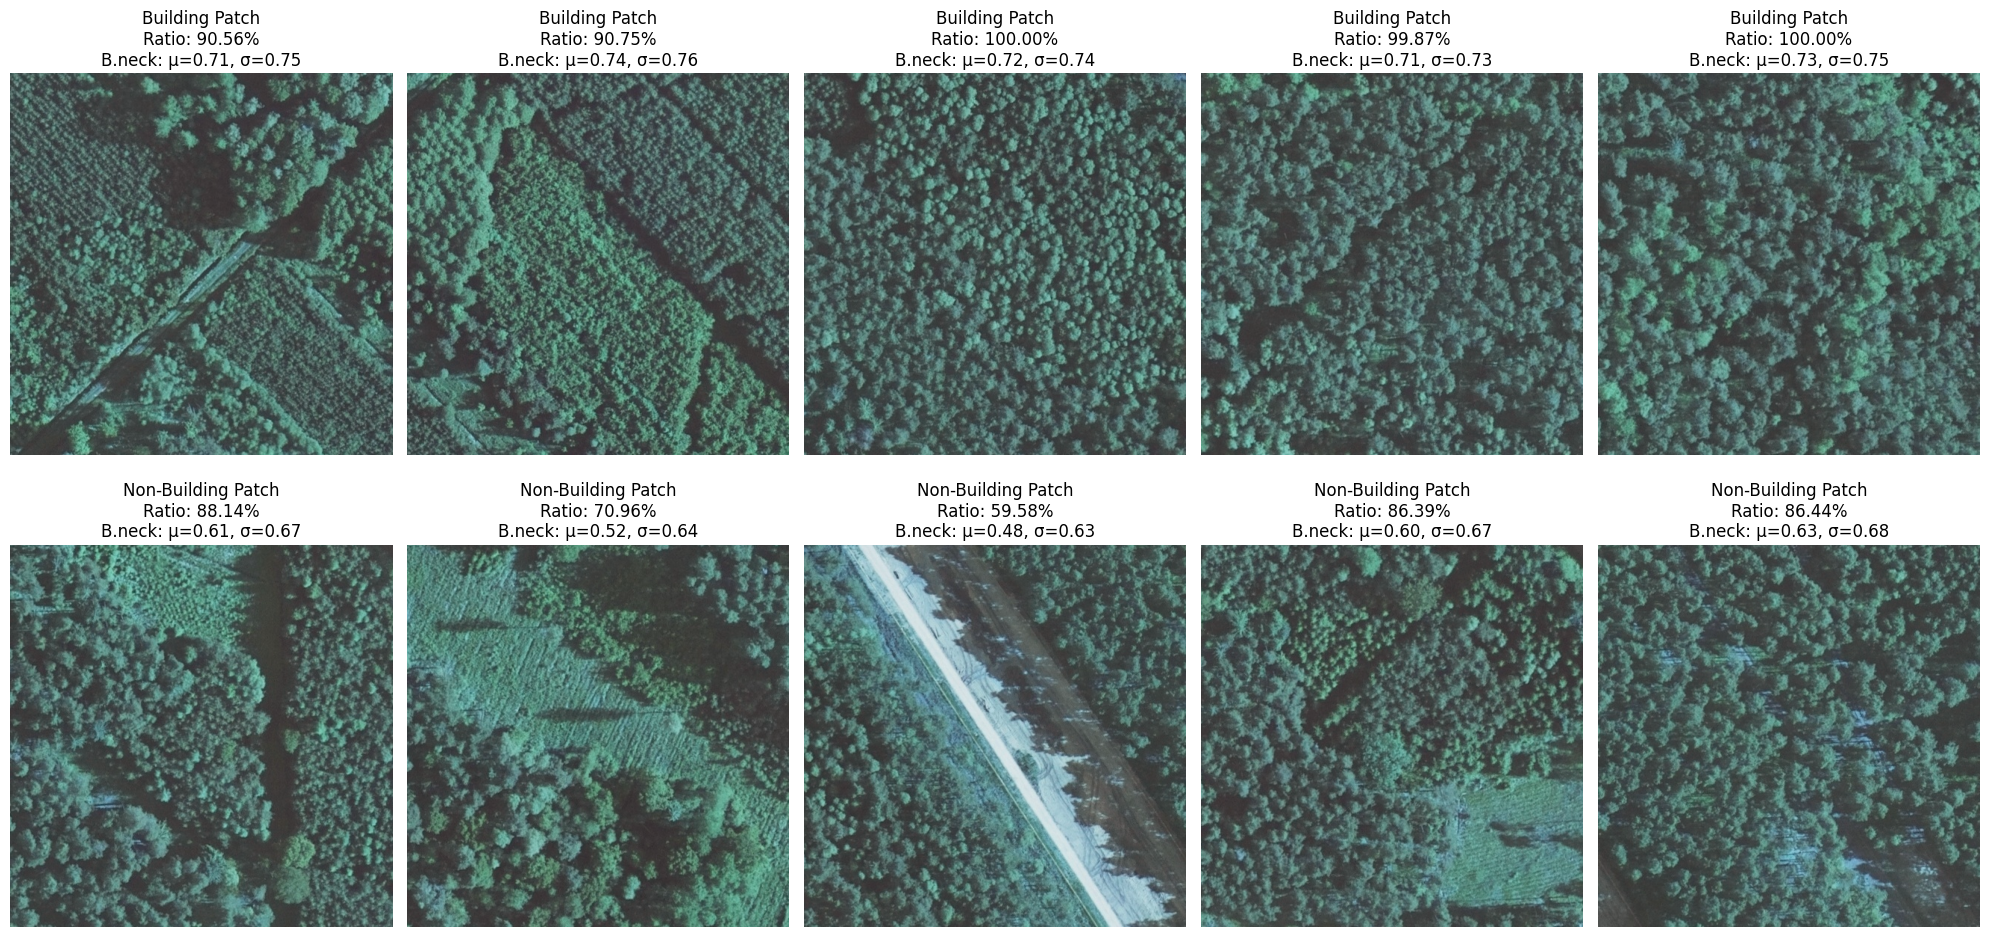

In [137]:
# Visualize sample patches
print("\nVisualizing sample patches...")
visualize_sample_patches(
    stats=stats,
    save_path="sample_patches_with_stats.png"
)


Analyzing channel differences...


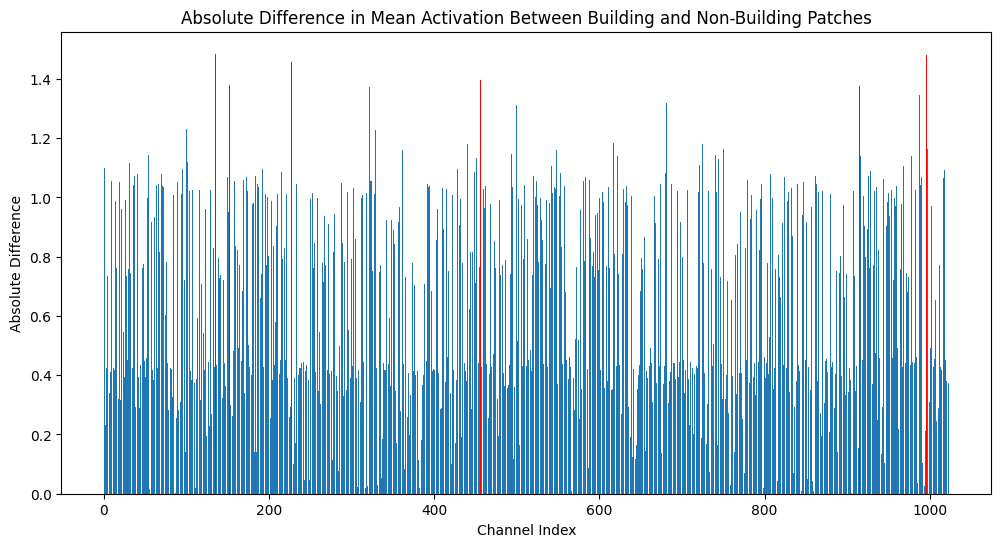


Top 10 discriminative channels:
1. Channel 135: Difference = 1.4851
   Building mean: 1.8839
   Non-building mean: 0.3988
   Ratio: 4.72x
2. Channel 996: Difference = 1.4812
   Building mean: 1.8725
   Non-building mean: 0.3913
   Ratio: 4.79x
3. Channel 676: Difference = 1.4704
   Building mean: 1.8749
   Non-building mean: 0.4045
   Ratio: 4.64x
4. Channel 227: Difference = 1.4568
   Building mean: 1.8627
   Non-building mean: 0.4059
   Ratio: 4.59x
5. Channel 419: Difference = 1.4489
   Building mean: 1.8362
   Non-building mean: 0.3873
   Ratio: 4.74x
6. Channel 700: Difference = 1.4426
   Building mean: 1.8292
   Non-building mean: 0.3865
   Ratio: 4.73x
7. Channel 378: Difference = 1.4349
   Building mean: 1.8160
   Non-building mean: 0.3811
   Ratio: 4.77x
8. Channel 456: Difference = 1.3973
   Building mean: 1.7814
   Non-building mean: 0.3840
   Ratio: 4.64x
9. Channel 152: Difference = 1.3790
   Building mean: 1.7643
   Non-building mean: 0.3853
   Ratio: 4.58x
10. Channel 9

In [138]:
# Analyze channel differences
print("\nAnalyzing channel differences...")
top_channels = analyze_channel_differences(
    stats=stats,
    top_n=10,
    save_path="channel_differences.png"
)

In [139]:
# Find optimal thresholds
print("\nFinding optimal thresholds...")
thresholds = find_optimal_thresholds(
    stats=stats,
    top_channels=top_channels
)


Finding optimal thresholds...
Average bottleneck magnitude - Building: 0.6713, Non-building: 0.3594, Ratio: 1.87x

Prior probabilities: Building = 0.16, Non-building = 0.84

Optimal thresholds for top channels:
Channel 135: Threshold = 0.4301 (Activation > Threshold), Estimated Accuracy = 1.0000
Channel 996: Threshold = 0.4225 (Activation > Threshold), Estimated Accuracy = 1.0000
Channel 676: Threshold = 0.4354 (Activation > Threshold), Estimated Accuracy = 1.0000
Channel 227: Threshold = 0.4366 (Activation > Threshold), Estimated Accuracy = 1.0000
Channel 419: Threshold = 0.4178 (Activation > Threshold), Estimated Accuracy = 1.0000
Channel 700: Threshold = 0.4169 (Activation > Threshold), Estimated Accuracy = 1.0000
Channel 378: Threshold = 0.4113 (Activation > Threshold), Estimated Accuracy = 1.0000
Channel 456: Threshold = 0.4134 (Activation > Threshold), Estimated Accuracy = 1.0000
Channel 152: Threshold = 0.4143 (Activation > Threshold), Estimated Accuracy = 1.0000
Channel 915: T

In [119]:
# Bottleneck Threshold Verification
# This script verifies the previously determined thresholds on test data

import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from tqdm import tqdm
import gc
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns

# Add these thresholds from your training results
# THRESHOLD_CONFIG = {
#     937: {'threshold': 0.2454, 'building_higher': True},
#     117: {'threshold': 0.2603, 'building_higher': True},
#     676: {'threshold': 0.2894, 'building_higher': True},
#     # 227: {'threshold': 0.2473, 'building_higher': False},
#     # 996: {'threshold': 0.2407, 'building_higher': False},
#     # 676: {'threshold': 0.2554, 'building_higher': False},
#     # 135: {'threshold': 0.2535, 'building_higher': False},
#     # 988: {'threshold': 0.2562, 'building_higher': False},
#     # 534: {'threshold': 0.2750, 'building_higher': False},
#     # 774: {'threshold': 0.2800, 'building_higher': True}
# }

THRESHOLD_CONFIG = {
    135: {'threshold': 0.0493, 'building_higher': True},
    996: {'threshold': 0.0450, 'building_higher': True},
    640: {'threshold': 0.0579, 'building_higher': True},
    700: {'threshold': 0.0420, 'building_higher': True},
    419: {'threshold': 0.0456, 'building_higher': True},
    # 676: {'threshold': 0.2554, 'building_higher': False},
    # 135: {'threshold': 0.2535, 'building_higher': False},
    # 988: {'threshold': 0.2562, 'building_higher': False},
    # 534: {'threshold': 0.2750, 'building_higher': False},
    # 774: {'threshold': 0.2800, 'building_higher': True}
}

def create_bottleneck_extractor(model):
    """
    Create a model that outputs only the bottleneck features.
    Args:
        model: The trained UNet model.
    Returns:
        bottleneck_extractor: Model that outputs bottleneck features.
    """
    class BottleneckExtractor(torch.nn.Module):
        def __init__(self, original_model):
            super(BottleneckExtractor, self).__init__()
            self.encoder_blocks = original_model.encoder_blocks
            self.pooling_layer = original_model.pooling_layer
            self.bottleneck = original_model.bottleneck
            
        def forward(self, x):
            # Pass through encoder
            skip_connections = []
            for encoder_block in self.encoder_blocks:
                x = encoder_block(x)
                skip_connections.append(x)
                x = self.pooling_layer(x)
                
            # Pass through bottleneck
            bottleneck_features = self.bottleneck(x)
            
            return bottleneck_features
    
    # Create and return the bottleneck extractor
    bottleneck_model = BottleneckExtractor(model)
    bottleneck_model.eval()  # Set to evaluation mode
    return bottleneck_model

def check_building_presence(mask, threshold=0.005):
    """
    Determine if a patch contains buildings based on the ground truth mask.
    Args:
        mask: Ground truth segmentation mask.
        threshold: Minimum ratio of building pixels to consider a patch as containing buildings.
    Returns:
        bool: True if patch contains buildings, False otherwise.
    """
    # Calculate ratio of building pixels (class 1) to total pixels
    building_pixels = (mask == 1).sum().item()
    total_pixels = mask.numel()
    building_ratio = building_pixels / total_pixels
    
    # Determine if patch has buildings based on threshold
    return building_ratio > threshold

def predict_with_bottleneck(bottleneck_features, channel, config):
    """
    Predict if a patch contains buildings based on a channel's mean activation.
    Args:
        bottleneck_features: Bottleneck features tensor.
        channel: Channel index to use for prediction.
        config: Dictionary with threshold and building_higher values.
    Returns:
        bool: True if predicted to contain buildings, False otherwise.
    """
    # Calculate mean activation for the specified channel
    channel_mean = bottleneck_features[channel].mean().item()
    
    # Apply threshold based on configuration
    if config['building_higher']:
        return channel_mean > config['threshold']
    else:
        return channel_mean < config['threshold']

def verify_thresholds(model, dataset, device, batch_size=8, has_building_threshold=0.005):
    """
    Verify bottleneck thresholds on a dataset.
    Args:
        model: The trained UNet model.
        dataset: Dataset to verify thresholds on.
        device: Device to run model on.
        batch_size: Batch size for processing.
        has_building_threshold: Threshold for determining if a patch contains buildings.
    Returns:
        results: Dictionary with verification results.
    """
    # Create bottleneck extractor
    bottleneck_extractor = create_bottleneck_extractor(model)
    bottleneck_extractor.to(device)
    
    # Create DataLoader
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=2)
    
    # Initialize results for each channel
    results = {channel: {'predictions': [], 'ground_truth': []} for channel in THRESHOLD_CONFIG.keys()}
    # Add a combined result using majority voting
    results['combined'] = {'predictions': [], 'ground_truth': []}
    
    # Process all batches
    with torch.no_grad():
        for images, masks in tqdm(dataloader, desc="Verifying thresholds"):
            # Move images to device
            images = images.to(device)
            
            # Extract bottleneck features
            bottleneck_features = bottleneck_extractor(images)
            
            # Process each sample in the batch
            for i, mask in enumerate(masks):
                # Check ground truth
                has_building = check_building_presence(mask, has_building_threshold)
                
                # Get bottleneck feature for this sample
                feature = bottleneck_features[i]
                
                # Make predictions using each channel
                channel_predictions = {}
                for channel, config in THRESHOLD_CONFIG.items():
                    # Predict using this channel
                    prediction = predict_with_bottleneck(feature, channel, config)
                    
                    # Store result
                    results[channel]['predictions'].append(prediction)
                    results[channel]['ground_truth'].append(has_building)
                    
                    # Store for combined prediction
                    channel_predictions[channel] = prediction
                
                # Combined prediction (majority voting)
                combined_prediction = any(channel_predictions.values())
                results['combined']['predictions'].append(combined_prediction)
                results['combined']['ground_truth'].append(has_building)
            
            # Free memory
            del bottleneck_features
            gc.collect()
            if device == 'cuda':
                torch.cuda.empty_cache()
    
    return results

def calculate_metrics(results):
    """
    Calculate and print performance metrics for each channel.
    Args:
        results: Dictionary with verification results.
    """
    print("\nPerformance on test set:")
    print(f"{'Channel':<10} {'Accuracy':<10} {'Precision':<10} {'Recall':<10} {'F1-Score':<10}")
    print("-" * 60)
    
    channel_metrics = {}
    
    for channel, data in results.items():
        y_true = np.array(data['ground_truth'])
        y_pred = np.array(data['predictions'])
        
        # Calculate metrics
        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred, zero_division=0)
        recall = recall_score(y_true, y_pred, zero_division=0)
        f1 = f1_score(y_true, y_pred, zero_division=0)
        
        channel_str = str(channel) if channel != 'combined' else 'Combined'
        print(f"{channel_str:<10} {accuracy:<10.4f} {precision:<10.4f} {recall:<10.4f} {f1:<10.4f}")
        
        channel_metrics[channel] = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1
        }
    
    return channel_metrics

def plot_confusion_matrices(results, save_path=None):
    """
    Plot confusion matrices for each channel's predictions.
    Args:
        results: Dictionary with verification results.
        save_path: Path to save the plot. If None, the plot is displayed.
    """
    # Calculate number of rows and columns for subplots
    num_channels = len(results)
    ncols = 3
    nrows = (num_channels + ncols - 1) // ncols
    
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 5, nrows * 4))
    axes = axes.flatten()
    
    channel_idx = 0
    for channel, data in results.items():
        y_true = np.array(data['ground_truth'])
        y_pred = np.array(data['predictions'])
        
        # Calculate confusion matrix
        cm = confusion_matrix(y_true, y_pred)
        
        # Plot confusion matrix
        ax = axes[channel_idx]
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax)
        
        # Set title and labels
        channel_str = str(channel) if channel != 'combined' else 'Combined'
        ax.set_title(f'Channel {channel_str}')
        ax.set_xlabel('Predicted')
        ax.set_ylabel('True')
        ax.xaxis.set_ticklabels(['No Building', 'Building'])
        ax.yaxis.set_ticklabels(['No Building', 'Building'])
        
        channel_idx += 1
    
    # Hide empty subplots
    for i in range(channel_idx, len(axes)):
        axes[i].axis('off')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
    
    plt.show()

def analyze_errors(results, dataset, model, device, save_path=None):
    """
    Analyze and visualize false positives and false negatives.
    Args:
        results: Dictionary with verification results.
        dataset: Dataset used for verification.
        model: The trained UNet model.
        device: Device to run model on.
        save_path: Path to save the plot. If None, the plot is displayed.
    """
    # Use the combined results for error analysis
    y_true = np.array(results['combined']['ground_truth'])
    y_pred = np.array(results['combined']['predictions'])
    
    # Find indices of false positives and false negatives
    false_positive_indices = np.where((y_true == 0) & (y_pred == 1))[0]
    false_negative_indices = np.where((y_true == 1) & (y_pred == 0))[0]
    
    # Limit to at most 5 of each
    false_positive_indices = false_positive_indices[:min(5, len(false_positive_indices))]
    false_negative_indices = false_negative_indices[:min(5, len(false_negative_indices))]
    
    # Create bottleneck extractor
    bottleneck_extractor = create_bottleneck_extractor(model)
    bottleneck_extractor.to(device)
    
    # Set up figure
    num_fp = len(false_positive_indices)
    num_fn = len(false_negative_indices)
    
    if num_fp == 0 and num_fn == 0:
        print("No errors found to visualize!")
        return
    
    nrows = 2 if num_fp > 0 and num_fn > 0 else 1
    ncols = max(num_fp, num_fn)
    
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 4, nrows * 4))
    
    # Function to process and display a sample
    def process_sample(idx, ax, error_type):
        image, mask = dataset[idx]
        image_tensor = image.unsqueeze(0).to(device)
        
        # Get bottleneck features
        with torch.no_grad():
            bottleneck_features = bottleneck_extractor(image_tensor)[0]
        
        # Calculate channel means
        channel_means = {channel: bottleneck_features[channel].mean().item() 
                         for channel in THRESHOLD_CONFIG.keys()}
        
        # Make predictions
        channel_preds = {}
        for channel, config in THRESHOLD_CONFIG.items():
            if config['building_higher']:
                channel_preds[channel] = channel_means[channel] > config['threshold']
            else:
                channel_preds[channel] = channel_means[channel] < config['threshold']
        
        # Display image
        ax.imshow(np.transpose(image.cpu().numpy(), (1, 2, 0)))
        
        # Add ground truth info
        has_building = check_building_presence(mask)
        building_ratio = ((mask == 1).sum().item() / mask.numel()) * 100
        
        # Add annotation
        title = f"{error_type}\nGround truth: {'Building' if has_building else 'No Building'}\n"
        title += f"Building ratio: {building_ratio:.2f}%\n"
        
        # Add top 3 channels with their values
        top_channels = sorted(channel_means.items(), 
                              key=lambda x: abs(x[1] - THRESHOLD_CONFIG[x[0]]['threshold']), 
                              reverse=True)[:3]
        
        for channel, mean in top_channels:
            config = THRESHOLD_CONFIG[channel]
            threshold = config['threshold']
            direction = '>' if config['building_higher'] else '<'
            pred = channel_preds[channel]
            title += f"Ch {channel}: {mean:.4f} {direction} {threshold:.4f} = {pred}\n"
            
        ax.set_title(title)
        ax.axis('off')
    
    # Process false positives
    if num_fp > 0:
        fp_row = 0
        for i, idx in enumerate(false_positive_indices):
            ax = axes[fp_row, i] if nrows > 1 else axes[i]
            process_sample(idx, ax, "False Positive")
    
    # Process false negatives
    if num_fn > 0:
        fn_row = 1 if nrows > 1 else 0
        for i, idx in enumerate(false_negative_indices):
            ax = axes[fn_row, i] if nrows > 1 else axes[i]
            process_sample(idx, ax, "False Negative")
    
    # Hide empty subplots
    if nrows > 1:
        for i in range(num_fp, ncols):
            axes[0, i].axis('off')
        for i in range(num_fn, ncols):
            axes[1, i].axis('off')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
    
    plt.show()



In [120]:
# Initialize the test dataset
print("\nInitializing test dataset...")
test_set = SegmentationDataset(mode="test")


Initializing test dataset...
Using the whole test set --> 1602


In [121]:
# Verify thresholds on test data
print("\nVerifying thresholds on test data...")
results = verify_thresholds(
    model=model,
    dataset=test_set,
    device=device,
    batch_size=8
)


Verifying thresholds on test data...


Verifying thresholds: 100%|██████████| 201/201 [01:09<00:00,  2.90it/s]


In [122]:
# Calculate and display metrics
metrics = calculate_metrics(results)


Performance on test set:
Channel    Accuracy   Precision  Recall     F1-Score  
------------------------------------------------------------
135        0.8627     0.9225     0.8823     0.9020    
996        0.8596     0.9284     0.8710     0.8988    
640        0.7004     0.7334     0.9137     0.8137    
700        0.8858     0.9390     0.8989     0.9185    
419        0.8645     0.9258     0.8814     0.9031    
Combined   0.7441     0.7394     0.9922     0.8474    



Plotting confusion matrices...


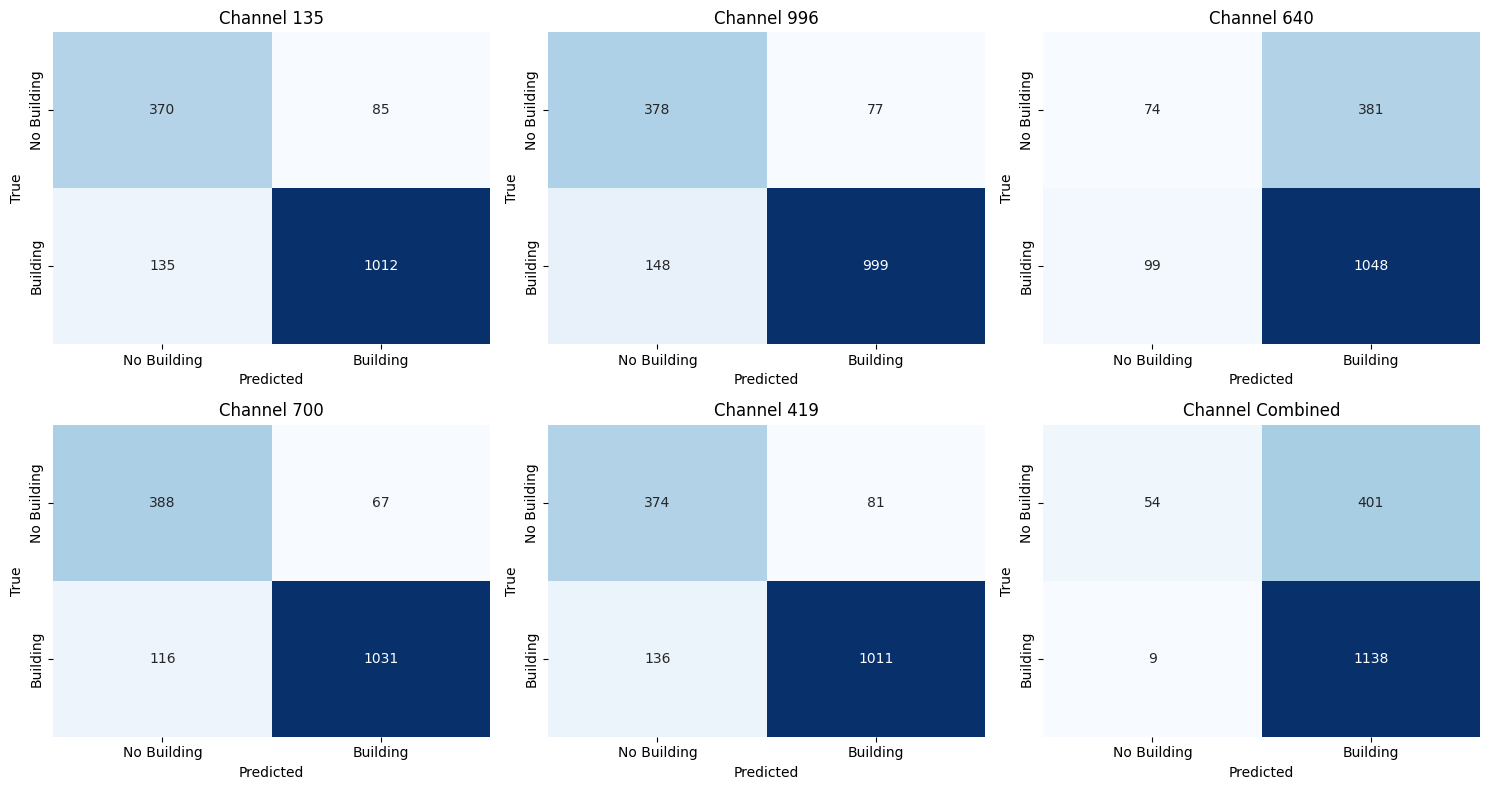

In [123]:
# Plot confusion matrices
print("\nPlotting confusion matrices...")
plot_confusion_matrices(results, save_path="confusion_matrices.png")



Analyzing prediction errors...


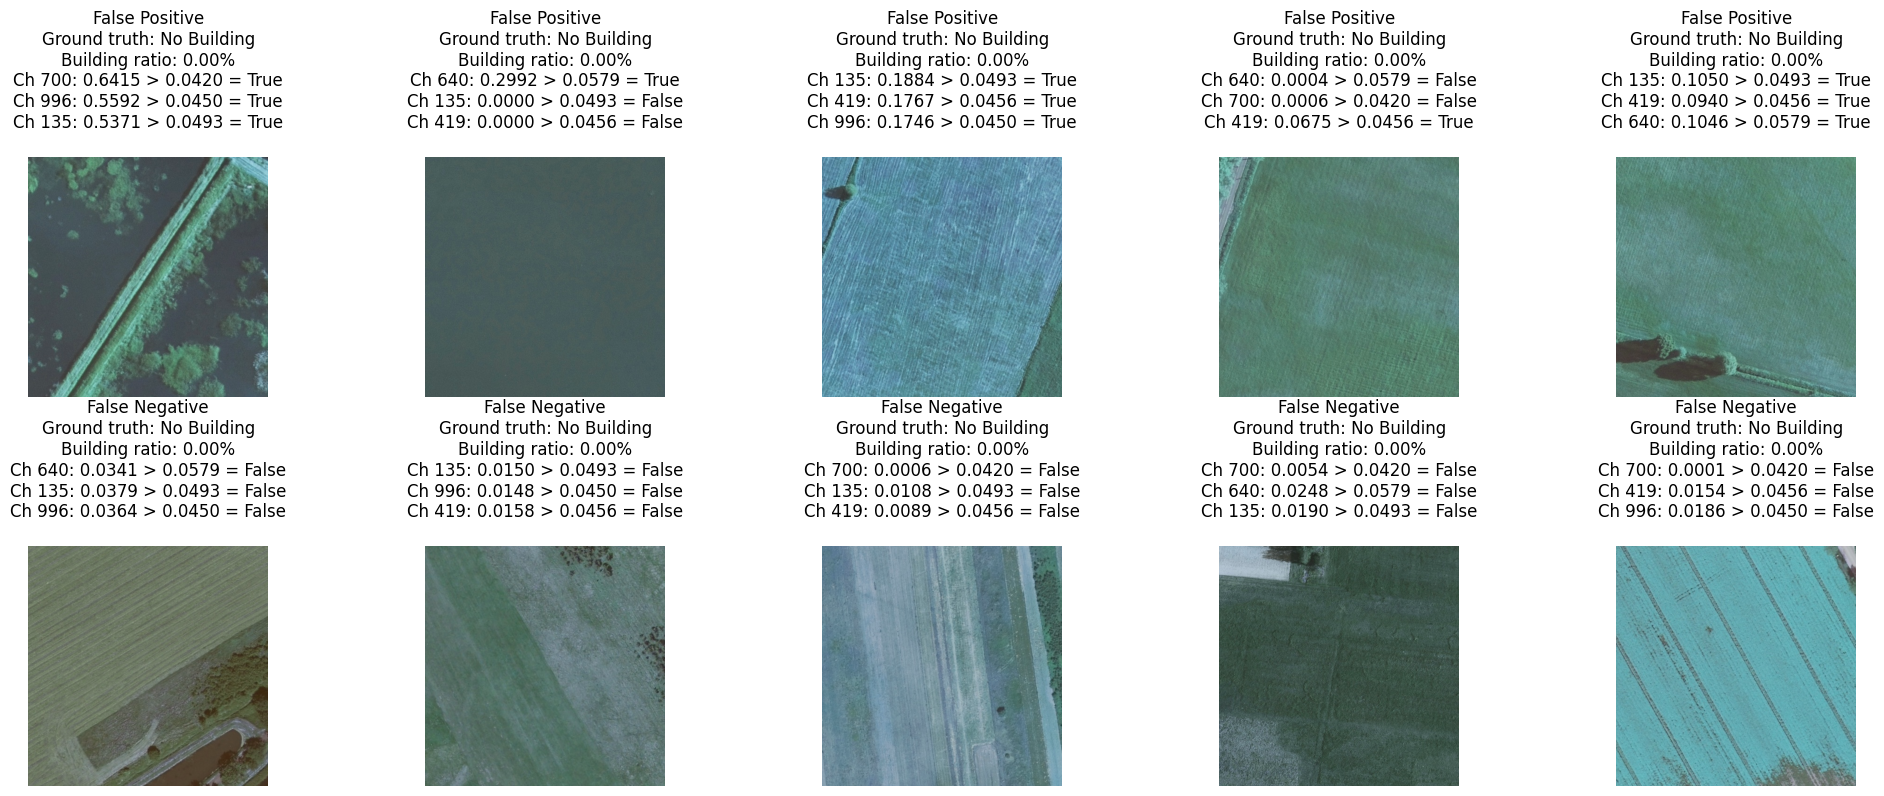

In [124]:
# Analyze errors
print("\nAnalyzing prediction errors...")
analyze_errors(
    results=results,
    dataset=test_set,
    model=model,
    device=device,
    save_path="error_analysis.png"
)

In [44]:
# Conditional U-Net Implementation with Bottleneck Thresholds (Fixed)
# This module implements a U-Net that conditionally executes the decoder based on bottleneck features

import torch
from torch import nn
import torchvision.transforms.functional as TF

# Threshold configuration derived from our analysis
THRESHOLD_CONFIG = {
    937: {'threshold': 0.2454, 'building_higher': True},
    117: {'threshold': 0.2603, 'building_higher': True},
    640: {'threshold': 0.2894, 'building_higher': True},
    # 227: {'threshold': 0.2473, 'building_higher': False},
    # 996: {'threshold': 0.2407, 'building_higher': False},
    # 676: {'threshold': 0.2554, 'building_higher': False},
    # 135: {'threshold': 0.2535, 'building_higher': False},
    # 988: {'threshold': 0.2562, 'building_higher': False},
    # 534: {'threshold': 0.2750, 'building_higher': False},
    # 774: {'threshold': 0.2800, 'building_higher': True}
}

FOREST_THRESHOLD_CONFIG = {
    135: {'threshold': 0.0493, 'forest_higher': True},
    996: {'threshold': 0.0450, 'forest_higher': True},
    640: {'threshold': 0.0579, 'forest_higher': True},
    700: {'threshold': 0.0420, 'forest_higher': True},
    419: {'threshold': 0.0456, 'forest_higher': True},
    # 676: {'threshold': 0.2554, 'building_higher': False},
    # 135: {'threshold': 0.2535, 'building_higher': False},
    # 988: {'threshold': 0.2562, 'building_higher': False},
    # 534: {'threshold': 0.2750, 'building_higher': False},
    # 774: {'threshold': 0.2800, 'building_higher':forest
}
# Double convolution block used in both the encoder and decoder parts of UNet
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, dilation=1):
        """
        Double convolutional layer with BatchNorm and ReLU activation.
        Args:
            in_channels (int): Number of input channels.
            out_channels (int): Number of output channels.
            dilation (int, optional): Dilation rate for convolutions. Defaults to 1.
        """
        super(DoubleConv, self).__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=dilation, stride=1, bias=False, dilation=dilation),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=dilation, stride=1, bias=False, dilation=dilation),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv_block(x)

# Conditional U-Net architecture that skips decoder for non-building patches
class ConditionalUNet(nn.Module):
    def __init__(self, in_channels, out_channels, features=[64, 128, 256, 512], dilation_rates=(1, 1, 1, 1), 
                 use_threshold=True, background_class=0):
        """
        U-Net architecture with conditional decoder execution.
        Args:
            in_channels (int): Number of input channels.
            out_channels (int): Number of output channels (number of classes).
            features (list of int, optional): Channels in each layer of encoder. Defaults to [64, 128, 256, 512].
            dilation_rates (tuple of int, optional): Dilation rates for each layer of encoder. Defaults to (1, 1, 1, 1).
            use_threshold (bool, optional): Whether to use bottleneck thresholds. Defaults to True.
            background_class (int, optional): Index of background class for default output. Defaults to 0.
        """
        super(ConditionalUNet, self).__init__()
        self.encoder_blocks = nn.ModuleList()
        self.decoder_blocks = nn.ModuleList()
        self.pooling_layer = nn.MaxPool2d(kernel_size=2, stride=2)
        self.use_threshold = use_threshold
        self.background_class = background_class
        self.out_channels = out_channels
        
        # Initialize statistics counters
        self.total_samples = 0
        self.decoder_executions = 0

        # Encoder: progressively downsample input while increasing channel depth
        for i, feature in enumerate(features):
            self.encoder_blocks.append(DoubleConv(in_channels, feature, dilation=dilation_rates[i]))
            in_channels = feature  # Update input channels for next block

        # Bottleneck: deepest part of the network
        self.bottleneck = DoubleConv(features[-1], features[-1] * 2)

        # Decoder: progressively upsample and decrease channel depth
        for i, feature in enumerate(reversed(features)):
            self.decoder_blocks.append(nn.ConvTranspose2d(feature * 2, feature, kernel_size=2, stride=2))  # Upsample
            self.decoder_blocks.append(DoubleConv(feature * 2, feature, dilation=dilation_rates[i]))  # Double convolution

        # Final 1x1 convolution for output
        self.output_conv = nn.Conv2d(features[0], out_channels, kernel_size=1, stride=1)

    # def check_bottleneck_contains_building(self, bottleneck_features):
    #     """
    #     Check if bottleneck features indicate presence of buildings.
    #     Uses the logical OR of multiple channel thresholds for high recall.
        
    #     Args:
    #         bottleneck_features (Tensor): Bottleneck feature tensor [B, C, H, W]
            
    #     Returns:
    #         Tensor: Boolean tensor indicating which samples in batch contain buildings [B]
    #     """
    #     batch_size = bottleneck_features.shape[0]
    #     contains_building = torch.zeros(batch_size, dtype=torch.bool, device=bottleneck_features.device)
        
    #     # Check each configured channel
    #     for channel, config in THRESHOLD_CONFIG.items():
    #         # Calculate channel mean for each sample in batch
    #         channel_means = bottleneck_features[:, channel].mean(dim=(1, 2))
            
    #         # Apply threshold based on configuration
    #         if config['building_higher']:
    #             channel_result = channel_means > config['threshold']
    #         else:
    #             channel_result = channel_means < config['threshold']
            
    #         # Logical OR with previous results (any channel indicates building)
    #         contains_building = contains_building | channel_result
        
    #     return contains_building


    def check_bottleneck_contains_building(self, bottleneck_features):
        """
        GPU-optimized two-stage check that closely follows the original logic.
        """
        batch_size = bottleneck_features.shape[0]
        device = bottleneck_features.device
        
        # Calculate all channel means at once for efficiency
        means = bottleneck_features.mean(dim=[2, 3])  # [B, C]
        
        # Stage 1: Building detection - using original logic but vectorized
        contains_building = torch.zeros(batch_size, dtype=torch.bool, device=device)
        
        # Process building channels - keeping exact same logic but without .item()
        for channel, config in THRESHOLD_CONFIG.items():
            if channel < means.shape[1]:  # Safety check
                threshold = config['threshold']
                if config['building_higher']:
                    channel_result = means[:, channel] > threshold
                else:
                    channel_result = means[:, channel] < threshold
                
                contains_building = contains_building | channel_result
        
        # If nothing passes first stage, return early
        if not contains_building.any():
            return contains_building
        
        # Create a copy to modify for the second stage
        final_selection = contains_building.clone()
        
        # Stage 2: Forest detection - staying extremely close to original logic
        forest_channels = [135, 700, 996, 943, 130, 240]  # Same channels as original
        forest_threshold = 1.0  # Same threshold
        
        # Process each sample but without transferring to CPU
        for i in range(batch_size):
            if contains_building[i]:  # Only check samples that passed stage 1
                is_forest = False
                
                # Check each forest channel - almost identical to original
                for channel in forest_channels:
                    if channel < means.shape[1]:  # Safety check
                        # Using direct tensor comparison without .item()
                        if means[i, channel] >= forest_threshold:
                            is_forest = True
                            break
                
                # If it's a forest, remove it from selection
                if is_forest:
                    final_selection[i] = False
        
        return final_selection

    def forward_full(self, x, skip_connections):
        """
        Execute full decoder path.
        
        Args:
            x (Tensor): Bottleneck feature tensor
            skip_connections (list): List of tensors from encoder for skip connections
            
        Returns:
            Tensor: Final segmentation output
        """
        # Decoding path with skip connections
        for idx in range(0, len(self.decoder_blocks), 2):
            x = self.decoder_blocks[idx](x)  # Upsample
            skip_connection = skip_connections[idx // 2]  # Fetch corresponding skip connection

            # Ensure size alignment for concatenation
            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            # Concatenate skip connection
            x = torch.cat((skip_connection, x), dim=1)
            x = self.decoder_blocks[idx + 1](x)  # Apply double conv block

        # Final output layer
        return self.output_conv(x)

    def forward_background_only(self, original_shape, device):
        """
        Create output filled with background class.
        
        Args:
            original_shape (tuple): Shape of original input [B, C, H, W]
            device: Device to create tensor on
            
        Returns:
            Tensor: Output filled with background class
        """
        batch_size, _, height, width = original_shape
        
        # Create output with correct shape for softmax
        output = torch.zeros((batch_size, self.out_channels, height, width), device=device)
        
        # Set background class to 1.0 (highest probability)
        output[:, self.background_class] = 1.0
        
        return output

    def forward(self, x):
        """
        Forward pass with conditional decoder execution.
        
        Args:
            x (Tensor): Input tensor [B, C, H, W]
            
        Returns:
            Tensor: Segmentation output
        """
        original_shape = x.shape
        device = x.device
        batch_size = x.shape[0]
        
        # Update statistics
        self.total_samples += batch_size
        
        # Store skip connections for later use
        skip_connections = []

        # Encoding path (always executed)
        for encoder_block in self.encoder_blocks:
            x = encoder_block(x)
            skip_connections.append(x)  # Save output for skip connection
            x = self.pooling_layer(x)  # Downsample

        # Bottleneck
        bottleneck_features = self.bottleneck(x)
        
        # Check if bottleneck features indicate building presence
        if self.use_threshold and self.training == False:  # Only apply during inference
            contains_building = self.check_bottleneck_contains_building(bottleneck_features)
        else:
            # During training, process all samples
            contains_building = torch.ones(batch_size, dtype=torch.bool, device=device)
        
        # Update decoder execution count
        self.decoder_executions += contains_building.sum().item()
        
        # If batch processing is enabled and at least one sample needs full processing
        if contains_building.any():
            # Process samples requiring the decoder
            if contains_building.all():
                # If all samples need the decoder, process the whole batch
                full_output = self.forward_full(bottleneck_features, skip_connections[::-1])
                return full_output
            else:
                # Mixed batch - we need to handle separately
                # Initialize a list to store outputs for each sample
                output_list = []
                
                for i in range(batch_size):
                    if contains_building[i]:
                        # Extract single sample and process with decoder
                        single_input = bottleneck_features[i:i+1]
                        single_skips = [s[i:i+1] for s in skip_connections[::-1]]
                        sample_output = self.forward_full(single_input, single_skips)
                        output_list.append(sample_output)
                    else:
                        # Create background-only output
                        background_output = self.forward_background_only(
                            (1, original_shape[1], original_shape[2], original_shape[3]),
                            device
                        )
                        output_list.append(background_output)
                
                # Concatenate all outputs along batch dimension
                return torch.cat(output_list, dim=0)
        else:
            # If no samples need the decoder, return all background
            return self.forward_background_only(original_shape, device)

    def get_execution_stats(self):
        """
        Calculate and return execution statistics.
        
        Returns:
            dict: Dictionary with execution statistics
        """
        return {
            'total_samples': self.total_samples,
            'decoder_executions': self.decoder_executions,
            'execution_percentage': 
                (self.decoder_executions / max(1, self.total_samples)) * 100
        }

    def reset_execution_stats(self):
        """Reset execution statistics."""
        self.total_samples = 0
        self.decoder_executions = 0

def load_conditional_unet(model_path, in_channels=3, out_channels=5, device='cuda'):
    """
    Load a pretrained U-Net model and convert it to ConditionalUNet.
    
    Args:
        model_path (str): Path to the pretrained U-Net model.
        in_channels (int): Number of input channels.
        out_channels (int): Number of output channels (classes).
        device (str): Device to load the model on.
        
    Returns:
        ConditionalUNet: Loaded conditional U-Net model.
    """
    # Create new conditional model
    conditional_model = ConditionalUNet(in_channels=in_channels, out_channels=out_channels).to(device)
    
    # Load pretrained weights
    pretrained_weights = torch.load(model_path, map_location=device)
    
    # Load weights into conditional model
    conditional_model.load_state_dict(pretrained_weights, strict=False)
    
    # Set to evaluation mode
    conditional_model.eval()
    
    print(f"Loaded pretrained model from {model_path} and converted to ConditionalUNet")
    
    return conditional_model

# Example of test set inference
def test_inference_example(model_path, test_dataset, batch_size=8, device='cuda'):
    """
    Example of running inference on a test set with the conditional model.
    
    Args:
        model_path (str): Path to the pretrained model.
        test_dataset: The test dataset.
        batch_size (int): Batch size for inference.
        device (str): Device to run inference on.
    """
    from torch.utils.data import DataLoader
    import time
    import matplotlib.pyplot as plt
    import numpy as np
    
    # Initialize dataloader
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
    
    # Load the model
    conditional_model = load_conditional_unet(
        model_path=model_path,
        in_channels=3,
        out_channels=5,
        device=device
    )
    conditional_model.eval()
    
    # Reset statistics
    conditional_model.reset_execution_stats()
    
    # Run inference
    start_time = time.time()
    all_predictions = []
    
    with torch.no_grad():
        for images, _ in test_loader:
            # Move to device
            images = images.to(device)
            
            # Run inference
            outputs = conditional_model(images)
            
            # Get predictions
            predictions = torch.argmax(outputs, dim=1).cpu().numpy()
            all_predictions.append(predictions)
    
    end_time = time.time()
    
    # Print statistics
    stats = conditional_model.get_execution_stats()
    print(f"Test set inference complete!")
    print(f"Total samples processed: {stats['total_samples']}")
    print(f"Samples requiring decoder: {stats['decoder_executions']} ({stats['execution_percentage']:.2f}%)")
    print(f"Total inference time: {end_time - start_time:.2f} seconds")
    
    return conditional_model, all_predictions

# Add this to your test_inference_example function or create a new function

def test_with_enhanced_statistics(model_path, test_dataset, batch_size=8, device='cuda', building_threshold=0.005):
    """
    Run inference on test set with enhanced statistics tracking.
    
    Args:
        model_path (str): Path to the pretrained model.
        test_dataset: The test dataset.
        batch_size (int): Batch size for inference.
        device (str): Device to run inference on.
        building_threshold (float): Threshold to determine if a ground truth mask contains buildings.
    
    Returns:
        dict: Enhanced statistics about the model's performance.
    """
    from torch.utils.data import DataLoader
    import time
    import numpy as np
    from sklearn.metrics import confusion_matrix
    
    # Initialize dataloader - use batch size of 1 for clearer statistics
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=2)
    
    # Load the model
    conditional_model = load_conditional_unet(
        model_path=model_path,
        in_channels=3,
        out_channels=5,
        device=device
    )
    conditional_model.eval()
    
    # Reset statistics
    conditional_model.reset_execution_stats()
    
    # Initialize enhanced statistics
    stats = {
        'total_images': 0,
        'contains_building': 0,  # Ground truth has buildings
        'decoder_executed': 0,   # Decoder was used
        'missed_buildings': 0,   # Images with buildings where decoder wasn't used
        'false_alarms': 0,       # Images without buildings where decoder was used
        'correctly_skipped': 0,  # Images without buildings where decoder wasn't used
        'correctly_processed': 0, # Images with buildings where decoder was used
        'processing_time': 0
    }
    
    # Lists to store per-image details
    image_details = []
    
    start_time = time.time()
    
    # Process each image individually for detailed statistics
    with torch.no_grad():
        for idx, (image, mask) in enumerate(test_loader):
            # Check if ground truth contains buildings
            has_building = (mask.squeeze() == 1).sum().item() > (building_threshold * mask.numel())
            
            # Move to device
            image = image.to(device)
            
            # Record decoder execution count before inference
            decoder_count_before = conditional_model.decoder_executions
            
            # Run inference
            image_start_time = time.time()
            output = conditional_model(image)
            image_time = time.time() - image_start_time
            
            # Check if decoder was executed for this image
            used_decoder = conditional_model.decoder_executions > decoder_count_before
            
            # Update statistics
            stats['total_images'] += 1
            stats['processing_time'] += image_time
            
            if has_building:
                stats['contains_building'] += 1
                if used_decoder:
                    stats['correctly_processed'] += 1
                else:
                    stats['missed_buildings'] += 1
            else:
                if used_decoder:
                    stats['false_alarms'] += 1
                else:
                    stats['correctly_skipped'] += 1
            
            if used_decoder:
                stats['decoder_executed'] += 1
            
            # Store image details for further analysis
            image_details.append({
                'idx': idx,
                'has_building': has_building,
                'used_decoder': used_decoder,
                'processing_time': image_time,
                'building_pixels': (mask.squeeze() == 1).sum().item(),
                'total_pixels': mask.numel(),
                'building_ratio': (mask.squeeze() == 1).sum().item() / mask.numel()
            })
    
    # Calculate additional statistics
    total_time = time.time() - start_time
    
    # Calculate recall and precision for building detection
    if stats['contains_building'] > 0:
        building_recall = stats['correctly_processed'] / stats['contains_building']
    else:
        building_recall = 1.0  # No buildings to detect
    
    if stats['decoder_executed'] > 0:
        building_precision = stats['correctly_processed'] / stats['decoder_executed']
    else:
        building_precision = 0.0  # No positive predictions
    
    # Add derived statistics
    stats['execution_percentage'] = (stats['decoder_executed'] / stats['total_images']) * 100
    stats['building_percentage'] = (stats['contains_building'] / stats['total_images']) * 100
    stats['building_recall'] = building_recall * 100
    stats['building_precision'] = building_precision * 100
    stats['total_time'] = total_time
    stats['avg_time_per_image'] = stats['processing_time'] / stats['total_images']
    
    # Print detailed statistics
    print("\n=== Enhanced Statistics ===")
    print(f"Total images processed: {stats['total_images']}")
    print(f"Images containing buildings: {stats['contains_building']} ({stats['building_percentage']:.2f}%)")
    print(f"Images where decoder executed: {stats['decoder_executed']} ({stats['execution_percentage']:.2f}%)")
    print("\n--- Building Detection Performance ---")
    print(f"Correctly processed buildings: {stats['correctly_processed']}")
    print(f"Missed buildings: {stats['missed_buildings']}")
    print(f"False alarms (unnecessary decoder use): {stats['false_alarms']}")
    print(f"Correctly skipped non-building images: {stats['correctly_skipped']}")
    print(f"Building detection recall: {stats['building_recall']:.2f}%")
    print(f"Building detection precision: {stats['building_precision']:.2f}%")
    print("\n--- Timing Statistics ---")
    print(f"Total processing time: {total_time:.2f} seconds")
    print(f"Average time per image: {stats['avg_time_per_image'] * 1000:.2f} ms")
    
    # Find and display examples of missed buildings
    missed_building_examples = [details for details in image_details if details['has_building'] and not details['used_decoder']]
    if missed_building_examples:
        print("\n--- Examples of Missed Buildings ---")
        for i, example in enumerate(missed_building_examples[:]):  # Show up to 5 examples
            print(f"Image {example['idx']}: Building ratio = {example['building_ratio']*100:.4f}%, Building pixels = {example['building_pixels']}")
    
    return conditional_model, stats, image_details

# Function to visualize examples of correct and incorrect decisions
def visualize_decision_examples(conditional_model, test_dataset, image_details, num_examples=2, device='cuda'):
    """
    Visualize examples of correct and incorrect decisions by the conditional model.
    
    Args:
        conditional_model: The conditional U-Net model.
        test_dataset: The test dataset.
        image_details: List of dictionaries with image details from test_with_enhanced_statistics.
        num_examples (int): Number of examples to show for each category.
        device (str): Device to run inference on.
    """
    import matplotlib.pyplot as plt
    import numpy as np
    import torch
    
    # Define categories to visualize
    categories = [
        ('missed_buildings', lambda x: x['has_building'] and not x['used_decoder']),
        ('false_alarms', lambda x: not x['has_building'] and x['used_decoder']),
        ('correctly_processed', lambda x: x['has_building'] and x['used_decoder']),
        ('correctly_skipped', lambda x: not x['has_building'] and not x['used_decoder'])
    ]
    
    # Find examples for each category
    examples = {}
    for category, condition in categories:
        examples[category] = [details for details in image_details if condition(details)]
        examples[category] = examples[category][:num_examples]  # Limit to num_examples
    
    # Create a figure for visualization
    num_categories = len(categories)
    max_examples = max([len(examples[category]) for category, _ in categories])
    
    if max_examples == 0:
        print("No examples found to visualize!")
        return
    
    # Create figure with subplots
    fig, axes = plt.subplots(num_categories, max_examples, 
                             figsize=(max_examples * 5, num_categories * 5), 
                             squeeze=False)
    
    # Get color map for masks from your original code
    # Assuming your original code defines labels_cmap for segmentation visualization
    import matplotlib.colors
    labels_cmap = matplotlib.colors.ListedColormap(["#000000", "#A9A9A9", "#8B8680", "#D3D3D3", "#FFFFFF"])
    
    # Process each category
    for i, (category, _) in enumerate(categories):
        for j, example in enumerate(examples[category]):
            if j < max_examples:
                # Get the image and mask
                image, mask = test_dataset[example['idx']]
                
                # Convert to display format
                image_display = np.transpose(image.numpy(), (1, 2, 0))
                
                # Display image and mask
                axes[i, j].imshow(image_display)
                
                # Overlay mask building areas with semi-transparency
                building_mask = (mask == 1).numpy()
                if building_mask.any():
                    building_overlay = np.zeros((building_mask.shape[0], building_mask.shape[1], 4))
                    building_overlay[building_mask, :3] = [1, 0, 0]  # Red for buildings
                    building_overlay[building_mask, 3] = 0.3  # Alpha
                    axes[i, j].imshow(building_overlay)
                
                # Set title
                title = f"{category.replace('_', ' ').title()}\n"
                title += f"Buildings: {'Yes' if example['has_building'] else 'No'}\n"
                title += f"Used Decoder: {'Yes' if example['used_decoder'] else 'No'}\n"
                title += f"Building Ratio: {example['building_ratio']*100:.2f}%"
                axes[i, j].set_title(title)
                axes[i, j].axis('off')
            else:
                axes[i, j].axis('off')  # Hide unused subplots
    
    plt.tight_layout()
    plt.savefig("decision_examples.png", bbox_inches="tight", dpi=150)
    plt.show()



In [24]:
#NEW
import torch
from torch import nn
import torchvision.transforms.functional as TF

# Define thresholds - keep these same values
BUILDING_CHANNELS = [937, 117, 640]
BUILDING_THRESHOLDS = [0.2454, 0.2603, 0.2894]
BUILDING_HIGHER = [True, True, True]

FOREST_CHANNELS = [135, 700, 996]
FOREST_THRESHOLDS = [1.0, 1.0, 1.0]

class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch, dilation=1):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=dilation, bias=False, dilation=dilation),
            nn.BatchNorm2d(out_ch), nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=dilation, bias=False, dilation=dilation),
            nn.BatchNorm2d(out_ch), nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.block(x)

class ConditionalUNet(nn.Module):
    def __init__(self, in_channels, out_channels,
                 features=[64,128,256,512], dilation_rates=(1,1,1,1),
                 use_threshold=True, background_class=0):
        super().__init__()
        self.use_threshold = use_threshold
        self.background_class = background_class
        self.out_channels = out_channels
        
        # Statistics counters
        self.total_samples = 0
        self.decoder_executions = 0

        # Build encoder
        self.encoders = nn.ModuleList()
        for i, f in enumerate(features):
            self.encoders.append(DoubleConv(in_channels, f, dilation_rates[i]))
            in_channels = f
        self.pool = nn.MaxPool2d(2)

        # Bottleneck
        self.bottleneck = DoubleConv(features[-1], features[-1]*2)

        # Build decoder
        self.decoders = nn.ModuleList()
        rev_feats = list(reversed(features))
        for i, f in enumerate(rev_feats):
            self.decoders.append(nn.ConvTranspose2d(f*2, f, 2, stride=2))
            self.decoders.append(DoubleConv(f*2, f, dilation_rates[i]))
        self.final_conv = nn.Conv2d(features[0], out_channels, 1)
        
        # Store the channel indices and thresholds
        self.building_channels = BUILDING_CHANNELS
        self.building_thresholds = BUILDING_THRESHOLDS
        self.building_higher = BUILDING_HIGHER
        self.forest_channels = FOREST_CHANNELS
        self.forest_thresholds = FOREST_THRESHOLDS

    def forward_full(self, bneck, skips):
        x = bneck
        for i in range(0, len(self.decoders), 2):
            x = self.decoders[i](x)
            skip = skips[i//2]
            if x.shape[-2:] != skip.shape[-2:]:
                x = TF.resize(x, skip.shape[-2:])
            x = torch.cat([skip, x], dim=1)
            x = self.decoders[i+1](x)
        return self.final_conv(x)

    def forward(self, x):
        B, C, H, W = x.shape
        device = x.device
        
        # Update statistics
        if not self.training:
            self.total_samples += B
            
        skips = []
        # Encoder
        for enc in self.encoders:
            x = enc(x)
            skips.append(x)
            x = self.pool(x)
        # Bottleneck
        bneck = self.bottleneck(x)

        # Default: process all images
        sel = torch.ones(B, dtype=torch.bool, device=device)
        
        # Apply thresholding if enabled and not training
        if self.use_threshold and not self.training:
            # Calculate mean activation for each channel
            means = torch.mean(bneck, dim=[2, 3])  # [B, C]
            
            # Building detection
            has_building = torch.zeros(B, dtype=torch.bool, device=device)
            
            # We need to handle the fact that our channel indices might be out of bounds
            # Instead, we'll manually extract and examine those specific channels
            for i, channel in enumerate(self.building_channels):
                # We need to safely check if this channel exists in the bottleneck
                if channel < means.shape[1]:
                    # This specific channel exists in the bottleneck
                    threshold = self.building_thresholds[i]
                    is_higher = self.building_higher[i]
                    
                    if is_higher:
                        cond = means[:, channel] > threshold
                    else:
                        cond = means[:, channel] < threshold
                    
                    has_building = has_building | cond
                else:
                    # If the specified channel doesn't exist, print a warning 
                    # (we'll skip this channel check)
                    print(f"Warning: Building channel {channel} is out of bounds for bottleneck with {means.shape[1]} channels")
            
            # Forest false-alarm detection
            is_forest = torch.ones(B, dtype=torch.bool, device=device)
            
            for i, channel in enumerate(self.forest_channels):
                if channel < means.shape[1]:
                    threshold = self.forest_thresholds[i]
                    channel_is_forest = means[:, channel] > threshold
                    is_forest = is_forest & channel_is_forest
                else:
                    print(f"Warning: Forest channel {channel} is out of bounds for bottleneck with {means.shape[1]} channels")
                    # If any forest channel is missing, we'll assume it's not a forest
                    is_forest = torch.zeros(B, dtype=torch.bool, device=device)
            
            # Final selection: has building AND NOT is forest
            sel = has_building & ~is_forest
            
            # Print debug info
            print(f"Debug - has_building: {has_building.sum().item()}/{B}, is_forest: {is_forest.sum().item()}/{B}, selected: {sel.sum().item()}/{B}")
        
        # Update decoder execution count
        if not self.training:
            self.decoder_executions += sel.sum().item()

        # Pre-fill background outputs
        out = torch.zeros(B, self.out_channels, H, W, device=device)
        out[:, self.background_class] = 1.0

        # If any selected, decode in one batch
        if sel.any():
            # collect batch slices
            b_bneck = bneck[sel]
            rev_skips = [s[sel] for s in reversed(skips)]
            decoded = self.forward_full(b_bneck, rev_skips)
            out[sel] = decoded
        
        return out
    
    def get_execution_stats(self):
        """
        Calculate and return execution statistics.
        
        Returns:
            dict: Dictionary with execution statistics
        """
        return {
            'total_samples': self.total_samples,
            'decoder_executions': self.decoder_executions,
            'execution_percentage': 
                (self.decoder_executions / max(1, self.total_samples)) * 100
        }

    def reset_execution_stats(self):
        """Reset execution statistics."""
        self.total_samples = 0
        self.decoder_executions = 0

def load_conditional_unet(model_path, in_channels=3, out_channels=5, device='cuda'):
    """
    Load a pretrained U-Net model and convert it to ConditionalUNet.
    
    Args:
        model_path (str): Path to the pretrained U-Net model.
        in_channels (int): Number of input channels.
        out_channels (int): Number of output channels (classes).
        device (str): Device to load the model on.
        
    Returns:
        ConditionalUNet: Loaded conditional U-Net model.
    """
    # Create new conditional model
    conditional_model = ConditionalUNet(in_channels=in_channels, out_channels=out_channels).to(device)
    
    # Load pretrained weights
    pretrained_weights = torch.load(model_path, map_location=device)
    
    # Load weights into conditional model
    conditional_model.load_state_dict(pretrained_weights, strict=False)
    
    # Set to evaluation mode
    conditional_model.eval()
    
    print(f"Loaded pretrained model from {model_path} and converted to ConditionalUNet")
    
    return conditional_model

def load_conditional_unet(model_path, in_channels=3, out_channels=5, device='cuda'):
    """
    Load a pretrained U-Net model and convert it to ConditionalUNet.
    
    Args:
        model_path (str): Path to the pretrained U-Net model.
        in_channels (int): Number of input channels.
        out_channels (int): Number of output channels (classes).
        device (str): Device to load the model on.
        
    Returns:
        ConditionalUNet: Loaded conditional U-Net model.
    """
    # Create new conditional model
    conditional_model = ConditionalUNet(in_channels=in_channels, out_channels=out_channels).to(device)
    
    # Load pretrained weights
    pretrained_weights = torch.load(model_path, map_location=device)
    
    # Load weights into conditional model
    conditional_model.load_state_dict(pretrained_weights, strict=False)
    
    # Set to evaluation mode
    conditional_model.eval()
    
    print(f"Loaded pretrained model from {model_path} and converted to ConditionalUNet")
    
    return conditional_model

# Example of test set inference
def test_inference_example(model_path, test_dataset, batch_size=8, device='cuda'):
    """
    Example of running inference on a test set with the conditional model.
    
    Args:
        model_path (str): Path to the pretrained model.
        test_dataset: The test dataset.
        batch_size (int): Batch size for inference.
        device (str): Device to run inference on.
    """
    from torch.utils.data import DataLoader
    import time
    import matplotlib.pyplot as plt
    import numpy as np
    
    # Initialize dataloader
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
    
    # Load the model
    conditional_model = load_conditional_unet(
        model_path=model_path,
        in_channels=3,
        out_channels=5,
        device=device
    )
    conditional_model.eval()
    
    # Reset statistics
    conditional_model.reset_execution_stats()
    
    # Run inference
    start_time = time.time()
    all_predictions = []
    
    with torch.no_grad():
        for images, _ in test_loader:
            # Move to device
            images = images.to(device)
            
            # Run inference
            outputs = conditional_model(images)
            
            # Get predictions
            predictions = torch.argmax(outputs, dim=1).cpu().numpy()
            all_predictions.append(predictions)
    
    end_time = time.time()
    
    # Print statistics
    stats = conditional_model.get_execution_stats()
    print(f"Test set inference complete!")
    print(f"Total samples processed: {stats['total_samples']}")
    print(f"Samples requiring decoder: {stats['decoder_executions']} ({stats['execution_percentage']:.2f}%)")
    print(f"Total inference time: {end_time - start_time:.2f} seconds")
    
    return conditional_model, all_predictions

# Add this to your test_inference_example function or create a new function

def test_with_enhanced_statistics(model_path, test_dataset, batch_size=8, device='cuda', building_threshold=0.005):
    """
    Run inference on test set with enhanced statistics tracking.
    
    Args:
        model_path (str): Path to the pretrained model.
        test_dataset: The test dataset.
        batch_size (int): Batch size for inference.
        device (str): Device to run inference on.
        building_threshold (float): Threshold to determine if a ground truth mask contains buildings.
    
    Returns:
        dict: Enhanced statistics about the model's performance.
    """
    from torch.utils.data import DataLoader
    import time
    import numpy as np
    from sklearn.metrics import confusion_matrix
    
    # Initialize dataloader - use batch size of 1 for clearer statistics
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=2)
    
    # Load the model
    conditional_model = load_conditional_unet(
        model_path=model_path,
        in_channels=3,
        out_channels=5,
        device=device
    )
    conditional_model.eval()
    
    # Reset statistics
    conditional_model.reset_execution_stats()
    
    # Initialize enhanced statistics
    stats = {
        'total_images': 0,
        'contains_building': 0,  # Ground truth has buildings
        'decoder_executed': 0,   # Decoder was used
        'missed_buildings': 0,   # Images with buildings where decoder wasn't used
        'false_alarms': 0,       # Images without buildings where decoder was used
        'correctly_skipped': 0,  # Images without buildings where decoder wasn't used
        'correctly_processed': 0, # Images with buildings where decoder was used
        'processing_time': 0
    }
    
    # Lists to store per-image details
    image_details = []
    
    start_time = time.time()
    
    # Process each image individually for detailed statistics
    with torch.no_grad():
        for idx, (image, mask) in enumerate(test_loader):
            # Check if ground truth contains buildings
            has_building = (mask.squeeze() == 1).sum().item() > (building_threshold * mask.numel())
            
            # Move to device
            image = image.to(device)
            
            # Record decoder execution count before inference
            decoder_count_before = conditional_model.decoder_executions
            
            # Run inference
            image_start_time = time.time()
            output = conditional_model(image)
            image_time = time.time() - image_start_time
            
            # Check if decoder was executed for this image
            used_decoder = conditional_model.decoder_executions > decoder_count_before
            
            # Update statistics
            stats['total_images'] += 1
            stats['processing_time'] += image_time
            
            if has_building:
                stats['contains_building'] += 1
                if used_decoder:
                    stats['correctly_processed'] += 1
                else:
                    stats['missed_buildings'] += 1
            else:
                if used_decoder:
                    stats['false_alarms'] += 1
                else:
                    stats['correctly_skipped'] += 1
            
            if used_decoder:
                stats['decoder_executed'] += 1
            
            # Store image details for further analysis
            image_details.append({
                'idx': idx,
                'has_building': has_building,
                'used_decoder': used_decoder,
                'processing_time': image_time,
                'building_pixels': (mask.squeeze() == 1).sum().item(),
                'total_pixels': mask.numel(),
                'building_ratio': (mask.squeeze() == 1).sum().item() / mask.numel()
            })
    
    # Calculate additional statistics
    total_time = time.time() - start_time
    
    # Calculate recall and precision for building detection
    if stats['contains_building'] > 0:
        building_recall = stats['correctly_processed'] / stats['contains_building']
    else:
        building_recall = 1.0  # No buildings to detect
    
    if stats['decoder_executed'] > 0:
        building_precision = stats['correctly_processed'] / stats['decoder_executed']
    else:
        building_precision = 0.0  # No positive predictions
    
    # Add derived statistics
    stats['execution_percentage'] = (stats['decoder_executed'] / stats['total_images']) * 100
    stats['building_percentage'] = (stats['contains_building'] / stats['total_images']) * 100
    stats['building_recall'] = building_recall * 100
    stats['building_precision'] = building_precision * 100
    stats['total_time'] = total_time
    stats['avg_time_per_image'] = stats['processing_time'] / stats['total_images']
    
    # Print detailed statistics
    print("\n=== Enhanced Statistics ===")
    print(f"Total images processed: {stats['total_images']}")
    print(f"Images containing buildings: {stats['contains_building']} ({stats['building_percentage']:.2f}%)")
    print(f"Images where decoder executed: {stats['decoder_executed']} ({stats['execution_percentage']:.2f}%)")
    print("\n--- Building Detection Performance ---")
    print(f"Correctly processed buildings: {stats['correctly_processed']}")
    print(f"Missed buildings: {stats['missed_buildings']}")
    print(f"False alarms (unnecessary decoder use): {stats['false_alarms']}")
    print(f"Correctly skipped non-building images: {stats['correctly_skipped']}")
    print(f"Building detection recall: {stats['building_recall']:.2f}%")
    print(f"Building detection precision: {stats['building_precision']:.2f}%")
    print("\n--- Timing Statistics ---")
    print(f"Total processing time: {total_time:.2f} seconds")
    print(f"Average time per image: {stats['avg_time_per_image'] * 1000:.2f} ms")
    
    # Find and display examples of missed buildings
    missed_building_examples = [details for details in image_details if details['has_building'] and not details['used_decoder']]
    if missed_building_examples:
        print("\n--- Examples of Missed Buildings ---")
        for i, example in enumerate(missed_building_examples[:]):  # Show up to 5 examples
            print(f"Image {example['idx']}: Building ratio = {example['building_ratio']*100:.4f}%, Building pixels = {example['building_pixels']}")
    
    return conditional_model, stats, image_details

# Function to visualize examples of correct and incorrect decisions
def visualize_decision_examples(conditional_model, test_dataset, image_details, num_examples=2, device='cuda'):
    """
    Visualize examples of correct and incorrect decisions by the conditional model.
    
    Args:
        conditional_model: The conditional U-Net model.
        test_dataset: The test dataset.
        image_details: List of dictionaries with image details from test_with_enhanced_statistics.
        num_examples (int): Number of examples to show for each category.
        device (str): Device to run inference on.
    """
    import matplotlib.pyplot as plt
    import numpy as np
    import torch
    
    # Define categories to visualize
    categories = [
        ('missed_buildings', lambda x: x['has_building'] and not x['used_decoder']),
        ('false_alarms', lambda x: not x['has_building'] and x['used_decoder']),
        ('correctly_processed', lambda x: x['has_building'] and x['used_decoder']),
        ('correctly_skipped', lambda x: not x['has_building'] and not x['used_decoder'])
    ]
    
    # Find examples for each category
    examples = {}
    for category, condition in categories:
        examples[category] = [details for details in image_details if condition(details)]
        examples[category] = examples[category][:num_examples]  # Limit to num_examples
    
    # Create a figure for visualization
    num_categories = len(categories)
    max_examples = max([len(examples[category]) for category, _ in categories])
    
    if max_examples == 0:
        print("No examples found to visualize!")
        return
    
    # Create figure with subplots
    fig, axes = plt.subplots(num_categories, max_examples, 
                             figsize=(max_examples * 5, num_categories * 5), 
                             squeeze=False)
    
    # Get color map for masks from your original code
    # Assuming your original code defines labels_cmap for segmentation visualization
    import matplotlib.colors
    labels_cmap = matplotlib.colors.ListedColormap(["#000000", "#A9A9A9", "#8B8680", "#D3D3D3", "#FFFFFF"])
    
    # Process each category
    for i, (category, _) in enumerate(categories):
        for j, example in enumerate(examples[category]):
            if j < max_examples:
                # Get the image and mask
                image, mask = test_dataset[example['idx']]
                
                # Convert to display format
                image_display = np.transpose(image.numpy(), (1, 2, 0))
                
                # Display image and mask
                axes[i, j].imshow(image_display)
                
                # Overlay mask building areas with semi-transparency
                building_mask = (mask == 1).numpy()
                if building_mask.any():
                    building_overlay = np.zeros((building_mask.shape[0], building_mask.shape[1], 4))
                    building_overlay[building_mask, :3] = [1, 0, 0]  # Red for buildings
                    building_overlay[building_mask, 3] = 0.3  # Alpha
                    axes[i, j].imshow(building_overlay)
                
                # Set title
                title = f"{category.replace('_', ' ').title()}\n"
                title += f"Buildings: {'Yes' if example['has_building'] else 'No'}\n"
                title += f"Used Decoder: {'Yes' if example['used_decoder'] else 'No'}\n"
                title += f"Building Ratio: {example['building_ratio']*100:.2f}%"
                axes[i, j].set_title(title)
                axes[i, j].axis('off')
            else:
                axes[i, j].axis('off')  # Hide unused subplots
    
    plt.tight_layout()
    plt.savefig("decision_examples.png", bbox_inches="tight", dpi=150)
    plt.show()



In [45]:
test_set = SegmentationDataset(mode="test")
device = "cuda" if torch.cuda.is_available() else "cpu"

# Option 1: Use the provided test function
conditional_model, stats, image_details = test_with_enhanced_statistics(
    model_path="/kaggle/input/unet-model-landcover-ai/pytorch/default/1/best_unet_model_0.25_loss",
    test_dataset=test_set,
    device="cuda"
)

Using the whole test set --> 1602
Loaded pretrained model from /kaggle/input/unet-model-landcover-ai/pytorch/default/1/best_unet_model_0.25_loss and converted to ConditionalUNet

=== Enhanced Statistics ===
Total images processed: 1602
Images containing buildings: 230 (14.36%)
Images where decoder executed: 695 (43.38%)

--- Building Detection Performance ---
Correctly processed buildings: 199
Missed buildings: 31
False alarms (unnecessary decoder use): 496
Correctly skipped non-building images: 876
Building detection recall: 86.52%
Building detection precision: 28.63%

--- Timing Statistics ---
Total processing time: 42.79 seconds
Average time per image: 13.74 ms

--- Examples of Missed Buildings ---
Image 210: Building ratio = 0.8369%, Building pixels = 2194
Image 269: Building ratio = 1.8757%, Building pixels = 4917
Image 425: Building ratio = 1.4240%, Building pixels = 3733
Image 441: Building ratio = 2.8164%, Building pixels = 7383
Image 485: Building ratio = 5.2635%, Building pix

In [161]:
# Forest vs Building Bottleneck Analysis
# This script analyzes bottleneck features to distinguish forest patches from building patches

import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader
from tqdm import tqdm
import gc
import pandas as pd
from sklearn.metrics import roc_curve, auc
import os

def create_bottleneck_extractor(model):
    """
    Create a model that outputs only the bottleneck features.
    Args:
        model: The trained UNet model.
    Returns:
        bottleneck_extractor: Model that outputs bottleneck features.
    """
    class BottleneckExtractor(torch.nn.Module):
        def __init__(self, original_model):
            super(BottleneckExtractor, self).__init__()
            self.encoder_blocks = original_model.encoder_blocks
            self.pooling_layer = original_model.pooling_layer
            self.bottleneck = original_model.bottleneck
            
        def forward(self, x):
            # Pass through encoder
            skip_connections = []
            for encoder_block in self.encoder_blocks:
                x = encoder_block(x)
                skip_connections.append(x)
                x = self.pooling_layer(x)
                
            # Pass through bottleneck
            bottleneck_features = self.bottleneck(x)
            
            return bottleneck_features
    
    # Create and return the bottleneck extractor
    bottleneck_model = BottleneckExtractor(model)
    bottleneck_model.eval()  # Set to evaluation mode
    return bottleneck_model

def analyze_patch_categories(test_dataset, conditional_model, device='cuda', building_threshold=0.005, forest_threshold=0.9):
    """
    Categorize patches into building, pure forest, false alarm forest, etc.
    
    Args:
        test_dataset: The test dataset.
        conditional_model: The conditional UNet model.
        device: Device to run model on.
        building_threshold: Minimum ratio of building pixels to consider a patch as containing buildings.
        forest_threshold: Minimum ratio of forest pixels to consider a patch as pure forest.
    
    Returns:
        dict: Categorized patch indices.
    """
    from torch.utils.data import DataLoader
    
    # Create bottleneck extractor
    bottleneck_extractor = create_bottleneck_extractor(conditional_model)
    bottleneck_extractor.to(device)
    
    # Initialize categories
    categories = {
        'building_patches': [],       # Patches containing buildings
        'pure_forest_patches': [],    # Patches with >90% forest, no buildings
        'false_alarm_forest': [],     # Forest patches triggering decoder
        'correctly_skipped_forest': [],  # Forest patches correctly skipped
        'other_patches': []           # Other patches
    }
    
    # Process each image individually
    loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=2)
    
    print("Categorizing patches...")
    for idx, (image, mask) in enumerate(tqdm(loader)):
        # Check mask contents
        mask = mask.squeeze()
        
        # Calculate ratios
        total_pixels = mask.numel()
        building_pixels = (mask == 1).sum().item()
        forest_pixels = (mask == 3).sum().item()  # Assuming 2 is forest/woodland class
        
        building_ratio = building_pixels / total_pixels
        forest_ratio = forest_pixels / total_pixels
        
        has_building = building_ratio > building_threshold
        is_pure_forest = forest_ratio > forest_threshold and building_ratio == 0
        
        # Check if decoder would be executed
        image = image.to(device)
        with torch.no_grad():
            bottleneck = bottleneck_extractor(image)
            # Use the conditional model's method to check if it would run the decoder
            would_run_decoder = conditional_model.check_bottleneck_contains_building(bottleneck)
        
        # Categorize the patch
        if has_building:
            categories['building_patches'].append(idx)
        elif is_pure_forest:
            categories['pure_forest_patches'].append(idx)
            if would_run_decoder:
                categories['false_alarm_forest'].append(idx)
            else:
                categories['correctly_skipped_forest'].append(idx)
        else:
            categories['other_patches'].append(idx)
    
    # Print category stats
    print("\nPatch Categories:")
    for category, indices in categories.items():
        print(f"{category}: {len(indices)} patches")
    
    return categories

def extract_bottleneck_features_for_categories(test_dataset, categories, bottleneck_extractor, device='cuda'):
    """
    Extract bottleneck features for categorized patches.
    
    Args:
        test_dataset: The test dataset.
        categories: Dictionary of categorized patch indices.
        bottleneck_extractor: Model that extracts bottleneck features.
        device: Device to run model on.
    
    Returns:
        dict: Bottleneck features for each category.
    """
    # Initialize dictionaries to store features
    bottleneck_features = {}
    
    # Categories to process
    process_categories = [
        'building_patches', 
        'pure_forest_patches', 
        'false_alarm_forest', 
        'correctly_skipped_forest'
    ]
    
    # Extract features for each category
    for category in process_categories:
        if len(categories[category]) == 0:
            print(f"No patches in category: {category}")
            continue
        
        print(f"Extracting features for {category}...")
        category_features = []
        
        # Process in small batches to avoid memory issues
        batch_size = 8
        for i in range(0, len(categories[category]), batch_size):
            batch_indices = categories[category][i:i+batch_size]
            batch_images = []
            
            # Load images
            for idx in batch_indices:
                image, _ = test_dataset[idx]
                batch_images.append(image)
            
            # Convert to tensor and move to device
            batch_tensor = torch.stack(batch_images).to(device)
            
            # Extract bottleneck features
            with torch.no_grad():
                batch_bottleneck = bottleneck_extractor(batch_tensor)
                
            # Move to CPU and convert to numpy to save memory
            batch_bottleneck = batch_bottleneck.cpu().numpy()
            category_features.append(batch_bottleneck)
            
            # Free up memory
            del batch_tensor, batch_bottleneck
            torch.cuda.empty_cache()
            gc.collect()
        
        # Concatenate all batches
        if category_features:
            bottleneck_features[category] = np.concatenate(category_features, axis=0)
            print(f"  Shape: {bottleneck_features[category].shape}")
    
    return bottleneck_features

def analyze_channel_activations(bottleneck_features):
    """
    Analyze channel activations to find discriminative channels.
    
    Args:
        bottleneck_features: Dictionary of bottleneck features for each category.
    
    Returns:
        tuple: (channel_means, discriminative_channels)
    """
    # Calculate mean activation per channel for each category
    channel_means = {}
    
    for category, features in bottleneck_features.items():
        # Calculate mean across all patches and spatial dimensions
        category_means = np.mean(features, axis=(0, 2, 3))
        channel_means[category] = category_means
    
    # Find channels that discriminate between forest false alarms and buildings
    if 'building_patches' in channel_means and 'false_alarm_forest' in channel_means:
        building_means = channel_means['building_patches']
        forest_false_alarm_means = channel_means['false_alarm_forest']
        
        # Calculate absolute difference
        diff = np.abs(building_means - forest_false_alarm_means)
        
        # Get top discriminative channels
        top_channels = np.argsort(diff)[::-1][:20]  # Top 20 channels
        
        print("\nTop discriminative channels between buildings and forest false alarms:")
        for i, channel in enumerate(top_channels[:10]):
            building_mean = building_means[channel]
            forest_mean = forest_false_alarm_means[channel]
            print(f"{i+1}. Channel {channel}: Building mean = {building_mean:.4f}, Forest FA mean = {forest_mean:.4f}, Diff = {diff[channel]:.4f}")
        
        return channel_means, top_channels
    else:
        print("Missing required categories for comparison")
        return channel_means, []

def plot_channel_distributions(bottleneck_features, top_channels, save_dir='channel_plots'):
    """
    Plot activation distributions for top channels across categories.
    
    Args:
        bottleneck_features: Dictionary of bottleneck features for each category.
        top_channels: List of channel indices to plot.
        save_dir: Directory to save plots.
    """
    # Create save directory if it doesn't exist
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    # Categories to include in plots
    plot_categories = [
        ('building_patches', 'Buildings'),
        ('false_alarm_forest', 'Forest (False Alarm)'),
        ('correctly_skipped_forest', 'Forest (Correctly Skipped)')
    ]
    
    # Colors for each category
    colors = ['blue', 'red', 'green']
    
    # Plot each channel
    for channel in top_channels[:10]:  # Plot top 10 channels
        plt.figure(figsize=(12, 6))
        
        for i, (category, label) in enumerate(plot_categories):
            if category in bottleneck_features:
                # Extract activations for this channel (flattened across spatial dimensions)
                activations = bottleneck_features[category][:, channel, :, :].flatten()
                
                # Plot histogram
                sns.histplot(activations, label=label, alpha=0.6, color=colors[i], kde=True)
        
        plt.title(f'Channel {channel} Activation Distribution')
        plt.xlabel('Activation Value')
        plt.ylabel('Frequency')
        plt.legend()
        plt.grid(alpha=0.3)
        plt.tight_layout()
        
        # Save plot
        plt.savefig(os.path.join(save_dir, f'channel_{channel}_distribution.png'))
        plt.close()

def find_optimal_forest_filter(bottleneck_features, top_channels, num_channels=3):
    """
    Find optimal combination of channels and thresholds to filter out forest patches.
    
    Args:
        bottleneck_features: Dictionary of bottleneck features for each category.
        top_channels: List of top discriminative channels.
        num_channels: Number of channels to use in the filter.
    
    Returns:
        dict: Optimal filter configuration.
    """
    # Validate required categories exist
    required_categories = ['building_patches', 'false_alarm_forest']
    if not all(category in bottleneck_features for category in required_categories):
        print("Missing required categories for filter optimization")
        return {}
    
    # Use only top N channels
    channels_to_try = top_channels[:num_channels]
    
    # Prepare data for ROC analysis
    forest_data = {}
    building_data = {}
    
    for channel in channels_to_try:
        # Extract mean activations for this channel for each sample
        forest_activations = np.mean(bottleneck_features['false_alarm_forest'][:, channel, :, :], axis=(1, 2))
        building_activations = np.mean(bottleneck_features['building_patches'][:, channel, :, :], axis=(1, 2))
        
        forest_data[channel] = forest_activations
        building_data[channel] = building_activations
    
    # Find optimal thresholds for each channel
    filter_config = {}
    
    for channel in channels_to_try:
        forest_activations = forest_data[channel]
        building_activations = building_data[channel]
        
        # Combine activations and create labels (0 for forest, 1 for building)
        all_activations = np.concatenate([forest_activations, building_activations])
        all_labels = np.concatenate([np.zeros_like(forest_activations), np.ones_like(building_activations)])
        
        # Calculate ROC curve
        fpr, tpr, thresholds = roc_curve(all_labels, all_activations)
        roc_auc = auc(fpr, tpr)
        
        # Find optimal threshold (maximize TPR-FPR)
        optimal_idx = np.argmax(tpr - fpr)
        optimal_threshold = thresholds[optimal_idx]
        
        # Determine if buildings have higher or lower activations
        building_mean = np.mean(building_activations)
        forest_mean = np.mean(forest_activations)
        buildings_higher = building_mean > forest_mean
        
        # Calculate performance at this threshold
        if buildings_higher:
            # Positive if activation > threshold
            building_correct = np.sum(building_activations > optimal_threshold) / len(building_activations)
            forest_correct = np.sum(forest_activations <= optimal_threshold) / len(forest_activations)
        else:
            # Positive if activation < threshold
            building_correct = np.sum(building_activations < optimal_threshold) / len(building_activations)
            forest_correct = np.sum(forest_activations >= optimal_threshold) / len(forest_activations)
        
        # Store configuration
        filter_config[channel] = {
            'threshold': float(optimal_threshold),
            'buildings_higher': buildings_higher,
            'building_correct': float(building_correct),
            'forest_correct': float(forest_correct),
            'auc': float(roc_auc)
        }
        
        print(f"\nChannel {channel}:")
        print(f"  Optimal threshold: {optimal_threshold:.4f}")
        print(f"  Buildings {'higher' if buildings_higher else 'lower'} than threshold")
        print(f"  Building samples correctly classified: {building_correct:.2%}")
        print(f"  Forest samples correctly classified: {forest_correct:.2%}")
        print(f"  ROC AUC: {roc_auc:.4f}")
    
    # Create a combined filter configuration
    combined_config = {
        'channels': list(filter_config.keys()),
        'channel_configs': filter_config
    }
    
    return combined_config

def validate_forest_filter(bottleneck_features, filter_config):
    """
    Validate the forest filter on all categories.
    
    Args:
        bottleneck_features: Dictionary of bottleneck features for each category.
        filter_config: Filter configuration from find_optimal_forest_filter.
    
    Returns:
        dict: Validation results.
    """
    results = {}
    
    # Apply filter to each category
    for category, features in bottleneck_features.items():
        # Skip if empty
        if len(features) == 0:
            continue
        
        # Count samples that pass the filter (predicted as buildings)
        pass_count = 0
        
        # Process each sample
        for i in range(len(features)):
            sample_passes = True
            
            # Check each channel in the filter
            for channel in filter_config['channels']:
                channel_config = filter_config['channel_configs'][channel]
                threshold = channel_config['threshold']
                buildings_higher = channel_config['buildings_higher']
                
                # Calculate mean activation for this channel
                activation = np.mean(features[i, channel, :, :])
                
                # Check if passes filter
                channel_passes = (activation > threshold) if buildings_higher else (activation < threshold)
                
                # If any channel fails, the sample fails
                if not channel_passes:
                    sample_passes = False
                    break
            
            if sample_passes:
                pass_count += 1
        
        # Calculate pass rate
        pass_rate = pass_count / len(features)
        results[category] = {
            'total': len(features),
            'pass_count': pass_count,
            'pass_rate': pass_rate
        }
    
    # Print results
    print("\nForest Filter Validation Results:")
    for category, result in results.items():
        print(f"{category}: {result['pass_count']}/{result['total']} pass ({result['pass_rate']:.2%})")
    
    return results

def simulate_optimized_inference(filter_config, validation_results):
    """
    Simulate inference with the optimized forest filter.
    
    Args:
        filter_config: Filter configuration.
        validation_results: Validation results.
    """
    # Calculate expected performance with filter
    if 'building_patches' in validation_results and 'false_alarm_forest' in validation_results:
        # Building recall
        building_recall = validation_results['building_patches']['pass_rate']
        
        # False alarm reduction
        false_alarm_reduction = 1 - validation_results['false_alarm_forest']['pass_rate']
        
        # Original stats from your results
        original_buildings = 230
        original_false_alarms = 771
        original_decoder_executions = 988
        total_images = 1602
        
        # Calculate new expected values
        new_buildings_detected = int(original_buildings * building_recall)
        new_false_alarms = int(original_false_alarms * (1 - false_alarm_reduction))
        new_decoder_executions = new_buildings_detected + new_false_alarms
        
        print("\nSimulated Performance with Forest Filter:")
        print(f"Original decoder executions: {original_decoder_executions}/{total_images} ({original_decoder_executions/total_images:.2%})")
        print(f"New decoder executions: {new_decoder_executions}/{total_images} ({new_decoder_executions/total_images:.2%})")
        print(f"Reduction in decoder usage: {original_decoder_executions - new_decoder_executions} images ({(original_decoder_executions - new_decoder_executions)/original_decoder_executions:.2%})")
        print(f"Building recall: {building_recall:.2%} (detecting {new_buildings_detected}/{original_buildings} building patches)")
        print(f"False alarm reduction: {false_alarm_reduction:.2%} (from {original_false_alarms} to {new_false_alarms})")
        
        # Calculate new precision
        new_precision = new_buildings_detected / max(1, new_decoder_executions)
        print(f"New precision: {new_precision:.2%} (was {217/988:.2%})")

def run_forest_building_analysis(model_path, test_dataset, device="cuda"):
    """
    Run the complete forest vs building analysis.
    
    Args:
        model_path: Path to the model file.
        test_dataset: The test dataset.
        device: Device to run on.
    
    Returns:
        dict: Analysis results and filter configuration.
    """
    
    # Load the model
    conditional_model = load_conditional_unet(
        model_path=model_path,
        in_channels=3,
        out_channels=5,
        device=device
    )
    conditional_model.eval()
    
    # Create bottleneck extractor
    bottleneck_extractor = create_bottleneck_extractor(conditional_model)
    bottleneck_extractor.to(device)
    
    # Step 1: Categorize patches
    print("Step 1: Categorizing patches...")
    categories = analyze_patch_categories(
        test_dataset=test_dataset,
        conditional_model=conditional_model,
        device=device
    )
    
    # Step 2: Extract bottleneck features for each category
    print("\nStep 2: Extracting bottleneck features...")
    bottleneck_features = extract_bottleneck_features_for_categories(
        test_dataset=test_dataset,
        categories=categories,
        bottleneck_extractor=bottleneck_extractor,
        device=device
    )
    
    # Step 3: Analyze channel activations
    print("\nStep 3: Analyzing channel activations...")
    channel_means, top_channels = analyze_channel_activations(bottleneck_features)
    
    # Step 4: Plot channel distributions
    print("\nStep 4: Plotting channel distributions...")
    plot_channel_distributions(
        bottleneck_features=bottleneck_features,
        top_channels=top_channels,
        save_dir='forest_building_plots'
    )
    
    # Step 5: Find optimal forest filter
    print("\nStep 5: Finding optimal forest filter...")
    filter_config = find_optimal_forest_filter(
        bottleneck_features=bottleneck_features,
        top_channels=top_channels,
        num_channels=3
    )
    
    # Step 6: Validate the filter
    print("\nStep 6: Validating forest filter...")
    validation_results = validate_forest_filter(
        bottleneck_features=bottleneck_features,
        filter_config=filter_config
    )
    
    # Step 7: Simulate optimized inference
    print("\nStep 7: Simulating optimized inference...")
    simulate_optimized_inference(
        filter_config=filter_config,
        validation_results=validation_results
    )
    
    # Return results
    return {
        'categories': categories,
        'channel_means': channel_means,
        'top_channels': top_channels,
        'filter_config': filter_config,
        'validation_results': validation_results
    }



In [162]:
results = run_forest_building_analysis(
    model_path="/kaggle/input/unet-model-landcover-ai/pytorch/default/1/best_unet_model_0.25_loss",
    test_dataset=train_set,
    device="cuda"
    
)

# Save the filter configuration
import json
with open('forest_filter_config.json', 'w') as f:
    json.dump(results['filter_config'], f, indent=2)

Loaded pretrained model from /kaggle/input/unet-model-landcover-ai/pytorch/default/1/best_unet_model_0.25_loss and converted to ConditionalUNet
Step 1: Categorizing patches...
Categorizing patches...


100%|██████████| 7470/7470 [02:17<00:00, 54.45it/s]



Patch Categories:
building_patches: 1009 patches
pure_forest_patches: 190 patches
false_alarm_forest: 178 patches
correctly_skipped_forest: 12 patches
other_patches: 6271 patches

Step 2: Extracting bottleneck features...
Extracting features for building_patches...
  Shape: (1009, 1024, 32, 32)
Extracting features for pure_forest_patches...
  Shape: (190, 1024, 32, 32)
Extracting features for false_alarm_forest...
  Shape: (178, 1024, 32, 32)
Extracting features for correctly_skipped_forest...
  Shape: (12, 1024, 32, 32)

Step 3: Analyzing channel activations...

Top discriminative channels between buildings and forest false alarms:
1. Channel 943: Building mean = 0.1229, Forest FA mean = 4.5750, Diff = 4.4521
2. Channel 130: Building mean = 0.1473, Forest FA mean = 4.4219, Diff = 4.2746
3. Channel 240: Building mean = 0.1897, Forest FA mean = 2.9518, Diff = 2.7621
4. Channel 350: Building mean = 0.2098, Forest FA mean = 2.7957, Diff = 2.5859
5. Channel 718: Building mean = 0.2239, Fo

TypeError: Object of type int64 is not JSON serializable

In [34]:
def calculate_building_iou(model, test_dataset, device='cuda', building_threshold=0.005):
    """
    Calculate IoU specifically for patches that contain buildings.
    
    Args:
        model: The conditional U-Net model.
        test_dataset: The test dataset.
        device: Device to run inference on.
        building_threshold: Threshold to determine if a ground truth mask contains buildings.
    
    Returns:
        float: IoU score for building class on building-containing patches.
    """
    from torch.utils.data import DataLoader
    import torch
    import numpy as np
    
    model.eval()
    
    # Initialize accumulators
    intersection = 0
    union = 0
    
    # Create DataLoader with batch size 1 for clear per-image statistics
    loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=2)
    
    # Collect building patch indices
    building_patch_indices = []
    
    # First pass: identify patches with buildings
    for idx, (_, mask) in enumerate(loader):
        has_building = (mask.squeeze() == 1).sum().item() > (building_threshold * mask.numel())
        if has_building:
            building_patch_indices.append(idx)
    
    print(f"Found {len(building_patch_indices)} patches containing buildings")
    
    # Second pass: calculate IoU on building patches
    with torch.no_grad():
        for idx in building_patch_indices:
            # Get image and mask
            image, mask = test_dataset[idx]
            image = image.unsqueeze(0).to(device)
            mask = mask.unsqueeze(0).to(device)
            
            # Run inference
            output = model(image)
            prediction = torch.argmax(output, dim=1)
            
            # Calculate IoU for building class (class index 1)
            pred_building = (prediction == 1)
            true_building = (mask == 1)
            
            # Calculate intersection and union
            batch_intersection = (pred_building & true_building).sum().item()
            batch_union = (pred_building | true_building).sum().item()
            
            # Add to accumulators
            intersection += batch_intersection
            union += batch_union
    
    # Calculate IoU
    if union > 0:
        building_iou = intersection / union
    else:
        building_iou = 0.0
    
    print(f"Building IoU on patches containing buildings: {building_iou:.4f}")
    
    return building_iou

In [35]:
# Calculate building IoU
building_iou = calculate_building_iou(
    model=conditional_model,
    test_dataset=test_set,
    device="cuda"
)

print(f"Building IoU on relevant patches: {building_iou}")

Found 230 patches containing buildings
Building IoU on patches containing buildings: 0.6981
Building IoU on relevant patches: 0.6981318391701516


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def infer_and_plot(model, dataset, indices, device, cmap, vmin=-0.5, vmax=4.5):
    """
    Run inference on selected dataset indices and plot:
      [Image | Ground‑Truth Mask | Predicted Mask]
    """
    model.eval()
    n = len(indices)
    fig, axs = plt.subplots(n, 3, figsize=(12, 4 * n))
    
    for row, idx in enumerate(indices):
        # 1) Load image and mask
        img, mask = dataset[idx]                  # img: C×H×W tensor, mask: H×W tensor
        img_np = img.numpy().transpose(1,2,0)     # to H×W×C for plotting
        
        # 2) Inference
        with torch.no_grad():
            inp = img.unsqueeze(0).to(device)     # 1×C×H×W
            pred_logits = model(inp)            
            pred_mask  = torch.argmax(pred_logits, dim=1).squeeze(0).cpu().numpy()
        
        # 3) Plot
        axs[row, 0].imshow(img_np)
        axs[row, 0].set_title(f"Image #{idx}")
        axs[row, 0].axis("off")
        
        axs[row, 1].imshow(mask.numpy(), cmap=cmap, vmin=vmin, vmax=vmax)
        axs[row, 1].set_title("Ground‑Truth")
        axs[row, 1].axis("off")
        
        axs[row, 2].imshow(pred_mask, cmap=cmap, vmin=vmin, vmax=vmax)
        axs[row, 2].set_title("Prediction")
        axs[row, 2].axis("off")
    
    plt.tight_layout()
    plt.show()


# ==== USAGE ====
# 1) pick your dataset (e.g. test_set, train_set or val_set)
# 2) choose indices you want to plot, e.g.:
indices_to_plot = [210,269,601,781,786,809,813,824,847,910,1280,1319,1320]  

infer_and_plot(
    model=load_model("/kaggle/input/unet-model-landcover-ai/pytorch/default/1/best_unet_model_0.25_loss"), 
    dataset=test_set,               # or train_set / val_set
    indices=indices_to_plot, 
    device=device, 
    cmap=labels_cmap
)


In [93]:
# Lightweight Classification Head Implementation
# This builds on the existing U-Net model to add a classification head on the bottleneck

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import gc
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns

class BuildingClassifier(nn.Module):
    """
    Lightweight classification head that connects to the U-Net bottleneck.
    """
    def __init__(self, bottleneck_channels=1024):
        super(BuildingClassifier, self).__init__()
        
        # Simple but effective architecture:
        # 1. Global Average Pooling to reduce spatial dimensions
        # 2. Two fully connected layers with dropout for regularization
        # 3. Final sigmoid activation for binary classification
        
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(bottleneck_channels, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, 64),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        x = self.global_pool(x)
        return self.classifier(x)

class UNetWithClassifier(nn.Module):
    """
    Wrapper class that combines the U-Net encoder + bottleneck with the classifier.
    """
    def __init__(self, unet_model, classifier):
        super(UNetWithClassifier, self).__init__()
        
        # Store the encoder and bottleneck from the U-Net
        self.encoder_blocks = unet_model.encoder_blocks
        self.pooling_layer = unet_model.pooling_layer
        self.bottleneck = unet_model.bottleneck
        
        # Add the classifier
        self.classifier = classifier
    
    def forward(self, x):
        # Pass through encoder
        skip_connections = []
        for encoder_block in self.encoder_blocks:
            x = encoder_block(x)
            skip_connections.append(x)
            x = self.pooling_layer(x)
        
        # Pass through bottleneck
        bottleneck_features = self.bottleneck(x)
        
        # Pass through classifier
        classification = self.classifier(bottleneck_features)
        
        return classification, bottleneck_features, skip_connections

class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        
    def forward(self, inputs, targets):
        bce_loss = F.binary_cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-bce_loss)
        focal_loss = ((1 - pt) ** self.gamma) * bce_loss
        return focal_loss.mean()
        
def train_classifier(model, train_loader, val_loader, device, epochs=10, lr=0.001, building_threshold=0.005):
    """
    Train the lightweight classifier on bottleneck features.
    
    Args:
        model: UNetWithClassifier model
        train_loader: DataLoader for training data
        val_loader: DataLoader for validation data
        device: Device to train on (cuda/cpu)
        epochs: Number of training epochs
        lr: Learning rate
        building_threshold: Threshold to determine if a patch contains buildings
    
    Returns:
        Trained model and training history
    """
    # Set up optimizer and loss function
    optimizer = optim.Adam(model.classifier.parameters(), lr=lr)
    # criterion = FocalLoss(gamma=2.0)
    pos_weight = torch.tensor([5.0]).to(device)  # Weight for the building class
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    # Initialize training history
    history = {
        'train_loss': [],
        'val_loss': [],
        'val_accuracy': [],
        'val_precision': [],
        'val_recall': [],
        'val_f1': []
    }
    
    # Training loop
    for epoch in range(epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        
        for images, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} - Training"):
            # Move data to device
            images = images.to(device)
            
            # Create binary labels: does the mask contain buildings?
            labels = torch.zeros(len(masks), 1, device=device)
            for i, mask in enumerate(masks):
                # Check if mask contains buildings (class 1)
                building_pixels = (mask == 1).sum().item()
                total_pixels = mask.numel()
                building_ratio = building_pixels / total_pixels
                
                # Assign label based on threshold
                if building_ratio > building_threshold:
                    labels[i, 0] = 1.0
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass - only compute classification output
            classifications, _, _ = model(images)
            
            # Compute loss
            loss = criterion(classifications, labels)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            # Update statistics
            running_loss += loss.item() * images.size(0)
        
        # Calculate epoch training loss
        epoch_train_loss = running_loss / len(train_loader.dataset)
        history['train_loss'].append(epoch_train_loss)
        
        # Validation phase
        model.eval()
        running_loss = 0.0
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for images, masks in tqdm(val_loader, desc="Validation"):
                # Move data to device
                images = images.to(device)
                
                # Create binary labels
                labels = torch.zeros(len(masks), 1, device=device)
                for i, mask in enumerate(masks):
                    building_pixels = (mask == 1).sum().item()
                    total_pixels = mask.numel()
                    building_ratio = building_pixels / total_pixels
                    
                    if building_ratio > building_threshold:
                        labels[i, 0] = 1.0
                
                # Forward pass
                classifications, _, _ = model(images)
                
                # Compute loss
                loss = criterion(classifications, labels)
                
                # Update statistics
                running_loss += loss.item() * images.size(0)
                
                # Store predictions and labels for metrics
                preds = (classifications > 0.5).float()
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        
        # Calculate validation metrics
        epoch_val_loss = running_loss / len(val_loader.dataset)
        history['val_loss'].append(epoch_val_loss)
        
        # Convert to numpy arrays
        all_preds = np.array(all_preds).flatten()
        all_labels = np.array(all_labels).flatten()
        
        # Calculate metrics
        accuracy = accuracy_score(all_labels, all_preds)
        precision = precision_score(all_labels, all_preds, zero_division=0)
        recall = recall_score(all_labels, all_preds, zero_division=0)
        f1 = f1_score(all_labels, all_preds, zero_division=0)
        
        history['val_accuracy'].append(accuracy)
        history['val_precision'].append(precision)
        history['val_recall'].append(recall)
        history['val_f1'].append(f1)
        
        # Print epoch statistics
        print(f"Epoch {epoch+1}/{epochs}")
        print(f"Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}")
        print(f"Val Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")
        print("-" * 60)
    
    return model, history

def plot_training_history(history, save_path=None):
    """
    Plot training and validation metrics.
    
    Args:
        history: Dictionary containing training history
        save_path: Path to save the plot
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot loss
    ax1.plot(history['train_loss'], label='Train Loss')
    ax1.plot(history['val_loss'], label='Validation Loss')
    ax1.set_title('Loss During Training')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    
    # Plot metrics
    ax2.plot(history['val_accuracy'], label='Accuracy')
    ax2.plot(history['val_precision'], label='Precision')
    ax2.plot(history['val_recall'], label='Recall')
    ax2.plot(history['val_f1'], label='F1-Score')
    ax2.set_title('Validation Metrics')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Score')
    ax2.legend()
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
    
    plt.show()

def evaluate_classifier(model, test_loader, device, building_threshold=0.005, save_path=None):
    """
    Evaluate the classifier on test data.
    
    Args:
        model: UNetWithClassifier model
        test_loader: DataLoader for test data
        device: Device to evaluate on (cuda/cpu)
        building_threshold: Threshold to determine if a patch contains buildings
        save_path: Path to save the confusion matrix
    
    Returns:
        Dictionary containing evaluation metrics
    """
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for images, masks in tqdm(test_loader, desc="Evaluating on test data"):
            # Move data to device
            images = images.to(device)
            
            # Create binary labels
            labels = torch.zeros(len(masks), 1)
            for i, mask in enumerate(masks):
                building_pixels = (mask == 1).sum().item()
                total_pixels = mask.numel()
                building_ratio = building_pixels / total_pixels
                
                if building_ratio > building_threshold:
                    labels[i, 0] = 1.0
            
            # Forward pass
            classifications, _, _ = model(images)
            
            # Store predictions and labels
            probs = classifications.cpu().numpy()
            preds = (classifications > 0.5).float().cpu().numpy()
            
            all_probs.extend(probs)
            all_preds.extend(preds)
            all_labels.extend(labels.numpy())
    
    # Convert to numpy arrays
    all_probs = np.array(all_probs).flatten()
    all_preds = np.array(all_preds).flatten()
    all_labels = np.array(all_labels).flatten()
    
    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, zero_division=0)
    recall = recall_score(all_labels, all_preds, zero_division=0)
    f1 = f1_score(all_labels, all_preds, zero_division=0)
    
    # Print metrics
    print("\nTest Set Evaluation:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    
    # Plot confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.xticks([0.5, 1.5], ['No Building', 'Building'])
    plt.yticks([0.5, 1.5], ['No Building', 'Building'])
    
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
    
    plt.show()
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'predictions': all_preds,
        'probabilities': all_probs,
        'labels': all_labels
    }

def create_efficient_unet(unet_model, classifier, device):
    """
    Create an efficient U-Net model that uses the classifier to decide whether to run the decoder.
    
    Args:
        unet_model: Original U-Net model
        classifier: Trained classifier
        device: Device to run model on
    
    Returns:
        Efficient U-Net model
    """
    class EfficientUNet(nn.Module):
        def __init__(self, unet_model, classifier, threshold=0.2):
            super(EfficientUNet, self).__init__()
            self.encoder_blocks = unet_model.encoder_blocks
            self.pooling_layer = unet_model.pooling_layer
            self.bottleneck = unet_model.bottleneck
            self.decoder_blocks = unet_model.decoder_blocks
            self.output_conv = unet_model.output_conv
            self.classifier = classifier
            self.threshold = threshold
            
            # For statistics
            self.decoder_skipped = 0
            self.decoder_used = 0
        
        def forward(self, x, always_decode=False):
            # Pass through encoder
            skip_connections = []
            for encoder_block in self.encoder_blocks:
                x = encoder_block(x)
                skip_connections.append(x)
                x = self.pooling_layer(x)
            
            # Pass through bottleneck
            bottleneck_features = self.bottleneck(x)
            
            # Determine if we should run the decoder
            with torch.no_grad():
                has_building = self.classifier(bottleneck_features) > self.threshold
                # Convert to Python boolean
                has_building = has_building.item() if has_building.numel() == 1 else has_building[0].item()
            
            # Update statistics
            if has_building or always_decode:
                self.decoder_used += 1
            else:
                self.decoder_skipped += 1
                # Return empty segmentation map of correct size
                return torch.zeros((1, unet_model.output_conv.out_channels, 
                                   skip_connections[0].size(2), 
                                   skip_connections[0].size(3)), 
                                  device=bottleneck_features.device)
            
            # Only continue with decoder if we have buildings or are forced to
            # Reverse order of skip connections for the decoder
            skip_connections = skip_connections[::-1]
            
            # Decoding path
            x = bottleneck_features
            for idx in range(0, len(self.decoder_blocks), 2):
                x = self.decoder_blocks[idx](x)  # Upsample
                skip_connection = skip_connections[idx // 2]  # Fetch corresponding skip connection
                
                # Ensure size alignment for concatenation
                if x.shape != skip_connection.shape:
                    x = nn.functional.interpolate(x, size=skip_connection.shape[2:])
                
                # Concatenate skip connection
                x = torch.cat((skip_connection, x), dim=1)
                x = self.decoder_blocks[idx + 1](x)  # Apply double conv block
            
            # Output layer
            return self.output_conv(x)
        
        def reset_statistics(self):
            self.decoder_skipped = 0
            self.decoder_used = 0
        
        def get_statistics(self):
            total = self.decoder_skipped + self.decoder_used
            if total == 0:
                return {'skipped': 0, 'used': 0, 'skipped_percent': 0, 'used_percent': 0}
            
            return {
                'skipped': self.decoder_skipped,
                'used': self.decoder_used,
                'skipped_percent': 100 * self.decoder_skipped / total,
                'used_percent': 100 * self.decoder_used / total
            }
    
    # Create and return the efficient model
    efficient_model = EfficientUNet(unet_model, classifier)
    efficient_model.to(device)
    return efficient_model

def test_efficient_unet(efficient_model, original_model, test_loader, device, save_path=None):
    """
    Test the efficient U-Net and compare with the original U-Net.
    
    Args:
        efficient_model: Efficient U-Net model
        original_model: Original U-Net model
        test_loader: DataLoader for test data
        device: Device to run inference on
        save_path: Path to save the visualization
    
    Returns:
        Dictionary with comparison metrics
    """
    efficient_model.eval()
    original_model.eval()
    
    # Reset statistics
    efficient_model.reset_statistics()
    
    # Select a small number of samples to compare (to avoid GPU memory issues)
    num_comparisons = 5
    comparison_samples = []
    
    # Sample indices uniformly across the test set
    indices = np.linspace(0, len(test_loader.dataset)-1, num_comparisons, dtype=int)
    
    with torch.no_grad():
        for idx in indices:
            image, mask = test_loader.dataset[idx]
            image = image.unsqueeze(0).to(device)
            
            # Run original model
            original_output = original_model(image)
            original_pred = torch.argmax(original_output, dim=1).squeeze().cpu().numpy()
            
            # Run efficient model
            efficient_output = efficient_model(image)
            efficient_pred = torch.argmax(efficient_output, dim=1).squeeze().cpu().numpy()
            
            # Check if decoder was used
            stats = efficient_model.get_statistics()
            decoder_used = stats['used'] == 1
            
            # Store results
            comparison_samples.append({
                'image': image.squeeze().cpu().numpy(),
                'mask': mask.numpy(),
                'original_pred': original_pred,
                'efficient_pred': efficient_pred,
                'decoder_used': decoder_used
            })
            
            # Reset statistics for next sample
            efficient_model.reset_statistics()
    
    # Run on the entire test set to get overall statistics
    efficient_model.reset_statistics()
    iou_values = []
    
    with torch.no_grad():
        for images, masks in tqdm(test_loader, desc="Running full test set"):
            images = images.to(device)
            
            # Run efficient model
            efficient_outputs = efficient_model(images)
            
            # Calculate IoU for building class (class 1)
            for i in range(images.size(0)):
                efficient_pred = torch.argmax(efficient_outputs[i:i+1], dim=1).squeeze().cpu().numpy()
                gt_mask = masks[i].numpy()
                
                # Calculate IoU for building class
                pred_building = efficient_pred == 1
                gt_building = gt_mask == 1
                
                intersection = np.logical_and(pred_building, gt_building).sum()
                union = np.logical_or(pred_building, gt_building).sum()
                
                iou = intersection / union if union > 0 else 0
                iou_values.append(iou)
    
    # Get final statistics
    final_stats = efficient_model.get_statistics()
    mean_iou = np.mean(iou_values)
    
    # Print statistics
    print("\nEfficient U-Net Statistics:")
    print(f"Decoder used: {final_stats['used']} times ({final_stats['used_percent']:.2f}%)")
    print(f"Decoder skipped: {final_stats['skipped']} times ({final_stats['skipped_percent']:.2f}%)")
    print(f"Mean IoU for building class: {mean_iou:.4f}")
    
    # Visualize comparisons
    fig, axes = plt.subplots(len(comparison_samples), 4, figsize=(20, 5*len(comparison_samples)))
    
    for i, sample in enumerate(comparison_samples):
        # Original image
        axes[i, 0].imshow(np.transpose(sample['image'], (1, 2, 0)))
        axes[i, 0].set_title("Original Image")
        axes[i, 0].axis('off')
        
        # Ground truth
        axes[i, 1].imshow(sample['mask'], cmap=labels_cmap, interpolation=None, vmin=-0.5, vmax=4.5)
        axes[i, 1].set_title("Ground Truth")
        axes[i, 1].axis('off')
        
        # Original U-Net prediction
        axes[i, 2].imshow(sample['original_pred'], cmap=labels_cmap, interpolation=None, vmin=-0.5, vmax=4.5)
        axes[i, 2].set_title("Original U-Net")
        axes[i, 2].axis('off')
        
        # Efficient U-Net prediction
        axes[i, 3].imshow(sample['efficient_pred'], cmap=labels_cmap, interpolation=None, vmin=-0.5, vmax=4.5)
        decoder_status = "Used" if sample['decoder_used'] else "Skipped"
        axes[i, 3].set_title(f"Efficient U-Net (Decoder: {decoder_status})")
        axes[i, 3].axis('off')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
    
    plt.show()
    
    return {
        'decoder_stats': final_stats,
        'mean_iou': mean_iou,
        'iou_values': iou_values
    }



In [ ]:
train_set = SegmentationDataset(mode="train")
val_set = SegmentationDataset(mode="val")
test_set = SegmentationDataset(mode="test")

In [ ]:
# Create DataLoaders
train_loader = DataLoader(train_set, batch_size=8, shuffle=True, num_workers=2)
val_loader = DataLoader(val_set, batch_size=8, shuffle=False, num_workers=2)
test_loader = DataLoader(test_set, batch_size=8, shuffle=False, num_workers=2)

In [ ]:
# Create the lightweight classifier
print("\nCreating lightweight classifier...")
classifier = BuildingClassifier(bottleneck_channels=1024)
classifier.to(device)

In [ ]:
# Create the combined model for training
combined_model = UNetWithClassifier(model, classifier)
combined_model.to(device)

In [ ]:
# Train the classifier
print("\nTraining the classifier...")
trained_model, history = train_classifier(
    model=combined_model,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    epochs=10,  # Adjust as needed
    lr=0.001
)

In [ ]:
# Plot training history
print("\nPlotting training history...")
plot_training_history(history, save_path="classifier_training_history.png")


In [ ]:
# Evaluate the classifier on test data
print("\nEvaluating the classifier...")
test_results = evaluate_classifier(
    model=trained_model,
    test_loader=test_loader,
    device=device,
    save_path="classifier_confusion_matrix.png"
)

In [ ]:
# Create the efficient U-Net
print("\nCreating efficient U-Net...")
efficient_unet = create_efficient_unet(
    unet_model=model,
    classifier=trained_model.classifier,
    device=device
)

In [ ]:
# Test the efficient U-Net
print("\nTesting efficient U-Net...")
efficiency_results = test_efficient_unet(
    efficient_model=efficient_unet,
    original_model=model,
    test_loader=test_loader,
    device=device,
    save_path="efficient_unet_comparison.png"
)

In [ ]:
# Save the classifier
torch.save(classifier.state_dict(), "building_classifier.pth")